# THINGS TO KNOW BEFORE RUNNING THIS CODE

If you do not mention kernel in SVR, it will automatically use rbf as default. Because I used rbf kernel, I don't have a code that do not specify the kernal

Due to the high dimensionality and the challenges of big data, the RBF and polynomial kernels are often approximated to reduce computational complexity. These approximations transform the non-linear kernels into a form that can be processed by linear methods, while preserving the characteristics of the original non-linear space.
There is a library called LinearSVR that is designed specifically for running linear support vector regression. Using this library can help run the code much faster, often achieving up to 1000x speed improvements.

I also placed # on evaluation of training dataset due to loading time/ my pc freezes if I run it. I think it is because of the capacity and big data. However, I know that training and testset have similar evaluation score due to the evaluation score on non standarisied version. If they are similar there, it should also be similar here.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

# Loading all dataset

### daily hexagon

In [2]:
daily_hexagon = pd.read_csv("C:/Users/A1DF42D/Downloads/daily_hexagon7_features.csv")

#save for later reuse 
hexagons = daily_hexagon["hex_id_7"]
hexagons2 = daily_hexagon["hex_id_POI"]
hexagonGeo= daily_hexagon["hex_id_geo"]

#dummies auf Basis von Geo Hexagon
daily_hexagon = pd.get_dummies(daily_hexagon, columns=["hex_id_geo"], dtype=float, drop_first=True)
daily_hexagon.shape #one less dummy column than categories is correct

daily_hexagon["hex_id_geo"] = hexagonGeo

#Stratified Sampling

# Split-Konfiguration
split_ratio = 0.8

# StratifiedShuffleSplit erstellen
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index für Train und Test Split
for train_index, test_index in sss.split(daily_hexagon, daily_hexagon['hex_id_geo']):
    daily_hexagon_train_set = daily_hexagon.iloc[train_index]
    daily_hexagon_test_set = daily_hexagon.iloc[test_index]

In [3]:
    #Gleiche Proportionen in Train and Test?
daily_hexagon_train_set['hex_id_geo'].value_counts(normalize=True)

hex_id_geo
872664cd1ffffff    0.009209
872664cf4ffffff    0.009147
872664ccaffffff    0.009147
872664564ffffff    0.009147
872664194ffffff    0.009147
                     ...   
872664ca8ffffff    0.006829
872664c86ffffff    0.006578
87275936bffffff    0.001472
872664c83ffffff    0.000282
872664cdeffffff    0.000188
Name: proportion, Length: 113, dtype: float64

In [4]:
daily_hexagon_test_set['hex_id_geo'].value_counts(normalize=True)

hex_id_geo
872664c8dffffff    0.009147
872664cd3ffffff    0.009147
872664c11ffffff    0.009147
872664d9bffffff    0.009147
872664520ffffff    0.009147
                     ...   
872664ca8ffffff    0.006766
872664c86ffffff    0.006515
87275936bffffff    0.001504
872664c83ffffff    0.000251
872664cdeffffff    0.000125
Name: proportion, Length: 113, dtype: float64

In [5]:
daily_hexagon_X_train = daily_hexagon_train_set.drop(["Unnamed: 0", "Date", "Number of Trips",'hex_id_7','hex_id_POI','hex_id_geo','lat_7','lon_7'], axis=1)
daily_hexagon_y_train = daily_hexagon_train_set["Number of Trips"]

daily_hexagon_X_test = daily_hexagon_test_set.drop(["Unnamed: 0", "Date", "Number of Trips",'hex_id_7','hex_id_POI','hex_id_geo','lat_7','lon_7'], axis=1)
daily_hexagon_y_test = daily_hexagon_test_set["Number of Trips"]

#Am besten auch Columns löschen, die Bezug zu Y haben
daily_hexagon_X_train.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

daily_hexagon_X_test.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

# Standardisierung
# Liste der bekannten Dummy-Variablen
known_dummy_columns = ['Business Hours', 'Business Travel', 'holiday', 'sports']

# Weitere Dummy-Variablen nach Namensmuster "_Geo" finden
geo_dummy_columns = daily_hexagon_X_train.columns[daily_hexagon_X_train.columns.str.contains('hex_id_geo_')]

# Alle Dummy-Variablen zusammenfassen
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numerische Spalten ohne Dummy-Variablen
numeric_columns = daily_hexagon_X_train.columns.difference(dummy_columns)

# Initialize the scaler
scaler = StandardScaler()

# Z-Standardisierung nur auf die numerischen Spalten anwenden
scaler = StandardScaler()
daily_hexagon_X_train[numeric_columns] = scaler.fit_transform(daily_hexagon_X_train[numeric_columns])

# Transformation auf dem Testset mit den im Training erlernten Parametern
daily_hexagon_X_test[numeric_columns] = scaler.transform(daily_hexagon_X_test[numeric_columns])

# Calculate mean and standard deviation
mean_daily_hexagon_y_train = daily_hexagon_y_train.mean()
std_daily_hexagon_y_train = daily_hexagon_y_train.std()
mean_daily_hexagon_y_test = daily_hexagon_y_test.mean()
std_daily_hexagon_y_test = daily_hexagon_y_test.std()

# Standardize y
daily_hexagon_y_train = (daily_hexagon_y_train - mean_daily_hexagon_y_train) / std_daily_hexagon_y_train
daily_hexagon_y_test = (daily_hexagon_y_test - mean_daily_hexagon_y_test) / std_daily_hexagon_y_test

#df to input data for model

daily_hexagon_X_train = daily_hexagon_X_train.to_numpy()
daily_hexagon_X_test = daily_hexagon_X_test.to_numpy()

#daily_hexagon_y_train = daily_hexagon_y_train.to_numpy()
#daily_hexagon_y_test = daily_hexagon_y_test.to_numpy()

### hourly hexagon

In [6]:
hourly_hexagon = pd.read_csv("C:/Users/A1DF42D/Downloads/hourly_hexagon_features.csv")

#save for later reuse
hexagons = hourly_hexagon["hex_id_7"]
hexagons2 = hourly_hexagon["hex_id_POI"]
hexagonGeo= hourly_hexagon["hex_id_geo"]

#dummies auf Basis von Geo Hexagon
hourly_hexagon = pd.get_dummies(hourly_hexagon, columns=["hex_id_geo"], dtype=float, drop_first=True)
hourly_hexagon.shape #one less dummy column than categories is correct

hourly_hexagon["hex_id_geo"] = hexagonGeo

#Stratified Sampling

# Split-Konfiguration
split_ratio = 0.8

# StratifiedShuffleSplit erstellen
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index für Train und Test Split
for train_index, test_index in sss.split(hourly_hexagon, hourly_hexagon['hex_id_geo']):
    hourly_hexagon_train_set = hourly_hexagon.loc[train_index]
    hourly_hexagon_test_set = hourly_hexagon.loc[test_index]

In [7]:
    #Gleiche Proportionen in Train and Test?
hourly_hexagon_train_set['hex_id_geo'].value_counts(normalize=True)

hex_id_geo
872664c1effffff    0.013804
872664c1affffff    0.013788
872664c16ffffff    0.013786
872759340ffffff    0.013747
872759341ffffff    0.013747
                     ...   
872664ca8ffffff    0.000948
872664c86ffffff    0.000737
87275936bffffff    0.000102
872664c83ffffff    0.000018
872664cdeffffff    0.000012
Name: proportion, Length: 113, dtype: float64

In [8]:
hourly_hexagon_test_set['hex_id_geo'].value_counts(normalize=True)

hex_id_geo
872664c1effffff    0.013806
872664c1affffff    0.013790
872664c16ffffff    0.013790
87275934effffff    0.013743
872759341ffffff    0.013743
                     ...   
872664ca8ffffff    0.000946
872664c86ffffff    0.000733
87275936bffffff    0.000102
872664c83ffffff    0.000016
872664cdeffffff    0.000008
Name: proportion, Length: 113, dtype: float64

In [9]:
#Entfernen von unnötigen Variablen für Modell
hourly_hexagon_X_train = hourly_hexagon_train_set.drop(["Unnamed: 0", "Hour", "Number of Trips",'hex_id_7','hex_id_POI','hex_id_geo','lat_7','lon_7'], axis=1)
hourly_hexagon_y_train = hourly_hexagon_train_set["Number of Trips"]

hourly_hexagon_X_test = hourly_hexagon_test_set.drop(["Unnamed: 0", "Hour", "Number of Trips",'hex_id_7','hex_id_POI','hex_id_geo','lat_7','lon_7'], axis=1)
hourly_hexagon_y_test = hourly_hexagon_test_set["Number of Trips"]

#Am besten auch Columns löschen, die Bezug zu Y haben
hourly_hexagon_X_train.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

hourly_hexagon_X_test.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)


# Standardisierung
# Liste der bekannten Dummy-Variablen
known_dummy_columns = ['Business Hours', 'Business Travel', 'holiday', 'sports']

# Weitere Dummy-Variablen nach Namensmuster "_Geo" finden
geo_dummy_columns = hourly_hexagon_X_train.columns[hourly_hexagon_X_train.columns.str.contains('hex_id_geo_')]

# Alle Dummy-Variablen zusammenfassen
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numerische Spalten ohne Dummy-Variablen
numeric_columns = hourly_hexagon_X_train.columns.difference(dummy_columns)

# Initialize the scaler
scaler = StandardScaler()

# Z-Standardisierung nur auf die numerischen Spalten anwenden
hourly_hexagon_X_train[numeric_columns] = scaler.fit_transform(hourly_hexagon_X_train[numeric_columns])

# Transformation auf dem Testset mit den im Training erlernten Parametern
hourly_hexagon_X_test[numeric_columns] = scaler.transform(hourly_hexagon_X_test[numeric_columns])

# Calculate mean and standard deviation
mean_hourly_hexagon_y_train = hourly_hexagon_y_train.mean()
std_hourly_hexagon_y_train = hourly_hexagon_y_train.std()
mean_hourly_hexagon_y_test = hourly_hexagon_y_test.mean()
std_hourly_hexagon_y_test = hourly_hexagon_y_test.std()

# Standardize y
hourly_hexagon_y_train = (hourly_hexagon_y_train - mean_hourly_hexagon_y_train) / std_hourly_hexagon_y_train
hourly_hexagon_y_test = (hourly_hexagon_y_test - mean_hourly_hexagon_y_test) / std_hourly_hexagon_y_test
#df to input data for model

hourly_hexagon_X_train = hourly_hexagon_X_train.to_numpy()
hourly_hexagon_X_test = hourly_hexagon_X_test.to_numpy()

#hourly_hexagon_y_train = hourly_hexagon_y_train.to_numpy()
#hourly_hexagon_y_test = hourly_hexagon_y_test.to_numpy()

### daily census

In [10]:
daily_census = pd.read_csv("C:/Users/A1DF42D/Downloads/daily_census_features.csv")

#save for later reuse
tracts = daily_census["Pickup Census Tract"]
tracts2 = daily_census["Census Tract POI"]
tractGeo= daily_census["Census Tract Geo"]

#dummies auf Basis von Geo Census
daily_census = pd.get_dummies(daily_census, columns=["Census Tract Geo"], dtype=float, drop_first=True)
daily_census.shape #one less dummy column than categories is correct

daily_census["Census Tract Geo"] = tractGeo

#Stratified Sampling

# Split-Konfiguration
split_ratio = 0.8

# StratifiedShuffleSplit erstellen
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index für Train und Test Split
for train_index, test_index in sss.split(daily_census, daily_census['Census Tract Geo']):
    daily_census_train_set = daily_census.loc[train_index]
    daily_census_test_set = daily_census.loc[test_index]

In [11]:
    #Gleiche Proportionen in Train and Test?
daily_census_train_set['Census Tract Geo'].value_counts(normalize=True)

Census Tract Geo
17031221300    0.008033
17031140602    0.007851
17031490902    0.007851
17031251500    0.007851
17031730400    0.007825
                 ...   
17031010600    0.000130
17031410600    0.000130
17031030103    0.000130
17031560100    0.000130
17031340600    0.000130
Name: proportion, Length: 283, dtype: float64

In [12]:
daily_census_test_set['Census Tract Geo'].value_counts(normalize=True)

Census Tract Geo
17031221300    0.008033
17031251500    0.007928
17031140602    0.007928
17031700401    0.007824
17031730400    0.007824
                 ...   
17031843100    0.000104
17031410500    0.000104
17031030103    0.000104
17031430101    0.000104
17031010600    0.000104
Name: proportion, Length: 283, dtype: float64

In [13]:
#Entfernen von unnötigen Variablen für Modell
daily_census_X_train = daily_census_train_set.drop(["Unnamed: 0", "Date", "Number of Trips",'Pickup Census Tract','Census Tract POI','Census Tract Geo','latitude','longitude'], axis=1)
daily_census_y_train = daily_census_train_set["Number of Trips"]

daily_census_X_test = daily_census_test_set.drop(["Unnamed: 0", "Date", "Number of Trips",'Pickup Census Tract','Census Tract POI','Census Tract Geo','latitude','longitude'], axis=1)
daily_census_y_test = daily_census_test_set["Number of Trips"]

#Am besten auch Columns löschen, die Bezug zu Y haben
daily_census_X_train.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

daily_census_X_test.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

# Standardisierung
# Liste der bekannten Dummy-Variablen
known_dummy_columns = ['Business Hours', 'Business Travel', 'holiday', 'sports']

# Weitere Dummy-Variablen nach Namensmuster "_Geo" finden
geo_dummy_columns = daily_census_X_train.columns[daily_census_X_train.columns.str.contains('Census Tract Geo_')]

# Alle Dummy-Variablen zusammenfassen
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numerische Spalten ohne Dummy-Variablen
numeric_columns = daily_census_X_train.columns.difference(dummy_columns)

# Initialize the scaler
scaler = StandardScaler()

# Z-Standardisierung nur auf die numerischen Spalten anwenden
scaler = StandardScaler()
daily_census_X_train[numeric_columns] = scaler.fit_transform(daily_census_X_train[numeric_columns])
daily_census_X_test[numeric_columns] = scaler.transform(daily_census_X_test[numeric_columns])


# Calculate mean and standard deviation
mean_daily_census_y_train = daily_census_y_train.mean()
std_daily_census_y_train = daily_census_y_train.std()
mean_daily_census_y_test = daily_census_y_test.mean()
std_daily_census_y_test = daily_census_y_test.std()

# Standardize y
daily_census_y_train = (daily_census_y_train - mean_daily_census_y_train) / std_daily_census_y_train
daily_census_y_test = (daily_census_y_test - mean_daily_census_y_test) / std_daily_census_y_test
#df to input data for model

daily_census_X_train = daily_census_X_train.to_numpy()
daily_census_X_test = daily_census_X_test.to_numpy()

#daily_census_y_train = daily_census_y_train.to_numpy()
#daily_census_y_test = daily_census_y_test.to_numpy()

### hourly census

In [14]:
hourly_census = pd.read_csv("C:/Users/A1DF42D/Downloads/hourly_census_features.csv")

#save for later reuse
tracts = hourly_census["Pickup Census Tract"]
tracts2 = hourly_census["Census Tract POI"]
tractGeo= hourly_census["Census Tract Geo"]


In [15]:

#dummies auf Basis von Geo census
hourly_census = pd.get_dummies(hourly_census, columns=["Census Tract Geo"], dtype=float, drop_first=True)
hourly_census.shape #one less dummy column than categories is correct

hourly_census["Census Tract Geo"] = tractGeo

#Stratified Sampling

# Split-Konfiguration
split_ratio = 0.8

# StratifiedShuffleSplit erstellen
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)


# Index für Train und Test Split
for train_index, test_index in sss.split(hourly_census, hourly_census['Census Tract Geo']):
    hourly_census_train_set = hourly_census.loc[train_index]
    hourly_census_test_set = hourly_census.loc[test_index]

In [16]:
        #Gleiche Proportionen in Train and Test?
hourly_census_train_set['Census Tract Geo'].value_counts(normalize=True)

Census Tract Geo
17031081000    0.017049
17031320400    0.017003
17031980000    0.016986
17031062200    0.016979
17031832900    0.016877
                 ...   
17031340600    0.000012
17031410600    0.000012
17031030103    0.000012
17031560100    0.000012
17031010600    0.000012
Name: proportion, Length: 283, dtype: float64

In [17]:
hourly_census_test_set['Census Tract Geo'].value_counts(normalize=True)

Census Tract Geo
17031081000    0.017052
17031320400    0.017003
17031980000    0.016984
17031062200    0.016974
17031832900    0.016877
                 ...   
17031010600    0.000010
17031560100    0.000010
17031430101    0.000010
17031340600    0.000010
17031030103    0.000010
Name: proportion, Length: 283, dtype: float64

In [18]:
#Entfernen von unnötigen Variablen für Modell
hourly_census_X_train = hourly_census_train_set.drop(["Unnamed: 0", "Hour", "Number of Trips",'Pickup Census Tract','Census Tract POI','Census Tract Geo','latitude','longitude'], axis=1)
hourly_census_y_train = hourly_census_train_set["Number of Trips"]

hourly_census_X_test = hourly_census_test_set.drop(["Unnamed: 0", "Hour", "Number of Trips",'Pickup Census Tract','Census Tract POI','Census Tract Geo','latitude','longitude'], axis=1)
hourly_census_y_test = hourly_census_test_set["Number of Trips"]

#Am besten auch Columns löschen, die Bezug zu Y haben
hourly_census_X_train.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

hourly_census_X_test.drop(['Trip Seconds', 'Tips', 'Extras','Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles'], axis=1, inplace=True)

# Standardisierung
# Liste der bekannten Dummy-Variablen
known_dummy_columns = ['Business Hours', 'Business Travel', 'holiday', 'sports']

# Weitere Dummy-Variablen nach Namensmuster "_Geo" finden
geo_dummy_columns = hourly_census_X_train.columns[hourly_census_X_train.columns.str.contains('Census Tract Geo_')]

# Alle Dummy-Variablen zusammenfassen
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numerische Spalten ohne Dummy-Variablen
numeric_columns = hourly_census_X_train.columns.difference(dummy_columns)

# Initialize the scaler
scaler = StandardScaler()

# Z-Standardisierung nur auf die numerischen Spalten anwenden
scaler = StandardScaler()
hourly_census_X_train[numeric_columns] = scaler.fit_transform(hourly_census_X_train[numeric_columns])
hourly_census_X_test[numeric_columns] = scaler.transform(hourly_census_X_test[numeric_columns])

# Calculate mean and standard deviation
mean_hourly_census_y_train = hourly_census_y_train.mean()
std_hourly_census_y_train = hourly_census_y_train.std()
mean_hourly_census_y_test = hourly_census_y_test.mean()
std_hourly_census_y_test = hourly_census_y_test.std()

# Standardize y
hourly_census_y_train = (hourly_census_y_train - mean_hourly_census_y_train) / std_hourly_census_y_train
hourly_census_y_test = (hourly_census_y_test - mean_hourly_census_y_test) / std_hourly_census_y_test
#df to input data for model

hourly_census_X_train = hourly_census_X_train.to_numpy()
hourly_census_X_test = hourly_census_X_test.to_numpy()

#hourly_census_y_train = hourly_census_y_train.to_numpy()
#hourly_census_y_test = hourly_census_y_test.to_numpy()

# Linear Kernel

### daily hexagon without grid searching

In [42]:
# Train SVM model with linear kernel
daily_hexagon_svm_linear = LinearSVR(verbose=True)
daily_hexagon_svm_linear.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
daily_hexagon_y_pred_linear_test = daily_hexagon_svm_linear.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_y_pred_linear_train = daily_hexagon_svm_linear.predict(daily_hexagon_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [43]:
# # Evaluate on the training set
daily_hexagon_mae_linear_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train)
daily_hexagon_mse_linear_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train)
daily_hexagon_rmse_linear_train = np.sqrt(daily_hexagon_mse_linear_train)
daily_hexagon_r2_linear_train = r2_score(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train)

def mase(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train):
     # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_y_pred_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_linear_train = mase(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train)

daily_hexagon_mape_linear_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_linear_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_y_pred_linear_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_linear_train = smape(daily_hexagon_y_train, daily_hexagon_y_pred_linear_train)

print(f'daily_hexagon SVM Model linear kernel (train) - MAE: {daily_hexagon_mae_linear_train}, MSE: {daily_hexagon_mse_linear_train}, RMSE: {daily_hexagon_rmse_linear_train}, R2: {daily_hexagon_r2_linear_train}, MASE: {daily_hexagon_mase_linear_train}, MAPE: {daily_hexagon_mape_linear_train}, SMAPE: {daily_hexagon_smape_linear_train}')

daily_hexagon SVM Model linear kernel (train) - MAE: 0.06793720145265464, MSE: 0.09080001614866343, RMSE: 0.301330410261997, R2: 0.9091971395066275, MASE: 0.18341733589469478, MAPE: 0.35516309797004403, SMAPE: 16.822507311767684


In [44]:
# Evaluate on the testing set
daily_hexagon_mae_linear_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test)
daily_hexagon_mse_linear_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test)
daily_hexagon_rmse_linear_test = np.sqrt(daily_hexagon_mse_linear_test)
daily_hexagon_r2_linear_test = r2_score(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test)

def mase(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_y_pred_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_linear_test = mase(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test)

daily_hexagon_mape_linear_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_linear_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_y_pred_linear_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_linear_test = smape(daily_hexagon_y_test, daily_hexagon_y_pred_linear_test)

print(f'daily_hexagon SVM Model linear kernel (test) - MAE: {daily_hexagon_mae_linear_test}, MSE: {daily_hexagon_mse_linear_test}, RMSE: {daily_hexagon_rmse_linear_test}, R2: {daily_hexagon_r2_linear_test}, MASE: {daily_hexagon_mase_linear_test}, MAPE: {daily_hexagon_mape_linear_test}, SMAPE: {daily_hexagon_smape_linear_test}')

daily_hexagon SVM Model linear kernel (test) - MAE: 0.06487729689547268, MSE: 0.07668066147690832, RMSE: 0.2769127326016417, R2: 0.9233097294176434, MASE: 0.17347933765818707, MAPE: 0.42111371341993725, SMAPE: 16.2663760164845


### daily hexagon with grid searching

In [45]:
# Parameter grid for LinearSVR
daily_hexagon_param_grid_linear = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Initialize and perform Grid Search for LinearSVR
daily_hexagon_grid_search_linear = GridSearchCV(LinearSVR(verbose=True), daily_hexagon_param_grid_linear, cv=5, scoring='neg_mean_absolute_error')
daily_hexagon_grid_search_linear.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Best parameters from Grid Search
print(f'Best parameters for linear kernel: {daily_hexagon_grid_search_linear.best_params_}')

# Get the best model from grid search
best_svm_linear = daily_hexagon_grid_search_linear.best_estimator_

# Predict on the test set
daily_hexagon_best_svm_linear_test = best_svm_linear.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_best_svm_linear_train = best_svm_linear.predict(daily_hexagon_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]Best parameters for linear kernel: {'C': 0.1}


C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
# Evaluate on the training set
daily_hexagon_best_mae_linear_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train)
daily_hexagon_best_mse_linear_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train)
daily_hexagon_best_rmse_linear_train = np.sqrt(daily_hexagon_best_mse_linear_train)
daily_hexagon_best_r2_linear_train = r2_score(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train)

def mase(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_best_svm_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_best_mase_linear_train = mase(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train)

daily_hexagon_best_mape_linear_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_best_svm_linear_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_best_svm_linear_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_best_smape_linear_train = smape(daily_hexagon_y_train, daily_hexagon_best_svm_linear_train)

print(f'daily_hexagon SVM Model linear kernel (train) - MAE: {daily_hexagon_best_mae_linear_train}, MSE: {daily_hexagon_best_mse_linear_train}, RMSE: {daily_hexagon_best_rmse_linear_train}, R2: {daily_hexagon_best_r2_linear_train}, MASE: {daily_hexagon_best_mase_linear_train}, MAPE: {daily_hexagon_best_mape_linear_train}, SMAPE: {daily_hexagon_best_smape_linear_train}')

NameError: name 'daily_hexagon_best_svm_linear_train' is not defined

In [47]:
# Evaluate on the testing set
daily_hexagon_best_mae_linear_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test)
daily_hexagon_best_mse_linear_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test)
daily_hexagon_best_rmse_linear_test = np.sqrt(daily_hexagon_best_mse_linear_test)
daily_hexagon_best_r2_linear_test = r2_score(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test)

def mase(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_best_svm_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_best_mase_linear_test = mase(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test)

daily_hexagon_best_mape_linear_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_best_svm_linear_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_best_svm_linear_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_best_smape_linear_test = smape(daily_hexagon_y_test, daily_hexagon_best_svm_linear_test)

print(f'daily_hexagon SVM Model linear kernel (test) - MAE: {daily_hexagon_best_mae_linear_test}, MSE: {daily_hexagon_best_mse_linear_test}, RMSE: {daily_hexagon_best_rmse_linear_test}, R2: {daily_hexagon_best_r2_linear_test}, MASE: {daily_hexagon_best_mase_linear_test}, MAPE: {daily_hexagon_best_mape_linear_test}, SMAPE: {daily_hexagon_best_smape_linear_test}')

daily_hexagon SVM Model linear kernel (test) - MAE: 0.06341903395821766, MSE: 0.07560532135497512, RMSE: 0.27496421831753876, R2: 0.9243852042939779, MASE: 0.16957999997625386, MAPE: 0.3944670122357065, SMAPE: 15.749184814252501


### hourly hexagon without grid searching

In [48]:
# Train SVM model with linear kernel
hourly_hexagon_svm_linear = LinearSVR(verbose=True)
hourly_hexagon_svm_linear.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Predict on the test set
hourly_hexagon_y_pred_linear_test = hourly_hexagon_svm_linear.predict(hourly_hexagon_X_test)

# Predict on the training set
hourly_hexagon_y_pred_linear_train = hourly_hexagon_svm_linear.predict(hourly_hexagon_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [49]:
# Evaluate on the training set
hourly_hexagon_mae_linear_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train)
hourly_hexagon_mse_linear_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train)
hourly_hexagon_rmse_linear_train = np.sqrt(hourly_hexagon_mse_linear_train)
hourly_hexagon_r2_linear_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train)

def mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_y_pred_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_mase_linear_train = mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train)

hourly_hexagon_mape_linear_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train)

# Custom function for SMAPE
def smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_linear_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_y_pred_linear_train) + np.abs(hourly_hexagon_y_train)))

hourly_hexagon_smape_linear_train = smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_linear_train)

print(f'hourly_hexagon SVM Model linear kernel (train) - MAE: {hourly_hexagon_mae_linear_train}, MSE: {hourly_hexagon_mse_linear_train}, RMSE: {hourly_hexagon_rmse_linear_train}, R2: {hourly_hexagon_r2_linear_train}, MASE: {hourly_hexagon_mase_linear_train}, MAPE: {hourly_hexagon_mape_linear_train}, SMAPE: {hourly_hexagon_smape_linear_train}')

In [50]:
# Evaluate on the testing set
hourly_hexagon_mae_linear_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test)
hourly_hexagon_mse_linear_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test)
hourly_hexagon_rmse_linear_test = np.sqrt(hourly_hexagon_mse_linear_test)
hourly_hexagon_r2_linear_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test)

def mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_y_pred_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_mase_linear_test = mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test)

hourly_hexagon_mape_linear_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test)

# Custom function for SMAPE
def smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_linear_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_y_pred_linear_test) + np.abs(hourly_hexagon_y_test)))

hourly_hexagon_smape_linear_test = smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_linear_test)

print(f'hourly_hexagon SVM Model linear kernel (test) - MAE: {hourly_hexagon_mae_linear_test}, MSE: {hourly_hexagon_mse_linear_test}, RMSE: {hourly_hexagon_rmse_linear_test}, R2: {hourly_hexagon_r2_linear_test}, MASE: {hourly_hexagon_mase_linear_test}, MAPE: {hourly_hexagon_mape_linear_test}, SMAPE: {hourly_hexagon_smape_linear_test}')

hourly_hexagon SVM Model linear kernel (test) - MAE: 0.16975494224104742, MSE: 0.4075116569043201, RMSE: 0.6383663970670136, R2: 0.592485131839213, MASE: 0.4615531314716895, MAPE: 0.839942791419351, SMAPE: 41.66600038969502


### hourly hexagon with grid searching

In [51]:
# Parameter grid for LinearSVR
hourly_hexagon_param_grid_linear = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Initialize and perform Grid Search for LinearSVR
hourly_hexagon_grid_search_linear = GridSearchCV(LinearSVR(verbose=True), hourly_hexagon_param_grid_linear, cv=5, scoring='neg_mean_absolute_error')
hourly_hexagon_grid_search_linear.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Best parameters from Grid Search
print(f'Best parameters for linear kernel: {hourly_hexagon_grid_search_linear.best_params_}')

# Get the best model from grid search
best_svm_linear = hourly_hexagon_grid_search_linear.best_estimator_

# Predict on the test set
hourly_hexagon_best_svm_linear_test = best_svm_linear.predict(hourly_hexagon_X_test)

# Predict on the training set
hourly_hexagon_best_svm_linear_train = best_svm_linear.predict(hourly_hexagon_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for linear kernel: {'C': 0.1}


In [52]:
# Evaluate on the training set
hourly_hexagon_best_mae_linear_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train)
hourly_hexagon_best_mse_linear_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train)
hourly_hexagon_best_rmse_linear_train = np.sqrt(hourly_hexagon_best_mse_linear_train)
hourly_hexagon_best_r2_linear_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train)

def mase(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_best_svm_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_best_mase_linear_train = mase(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train)

hourly_hexagon_best_mape_linear_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train)

# Custom function for SMAPE
def smape(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_best_svm_linear_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_best_svm_linear_train) + np.abs(hourly_hexagon_y_train)))

hourly_hexagon_best_smape_linear_train = smape(hourly_hexagon_y_train, hourly_hexagon_best_svm_linear_train)

print(f'hourly_hexagon SVM Model linear kernel (train) - MAE: {hourly_hexagon_best_mae_linear_train}, MSE: {hourly_hexagon_best_mse_linear_train}, RMSE: {hourly_hexagon_best_rmse_linear_train}, R2: {hourly_hexagon_best_r2_linear_train}, MASE: {hourly_hexagon_best_mase_linear_train}, MAPE: {hourly_hexagon_best_mape_linear_train}, SMAPE: {hourly_hexagon_best_smape_linear_train}')

In [53]:
# Evaluate on the testing set
hourly_hexagon_best_mae_linear_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test)
hourly_hexagon_best_mse_linear_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test)
hourly_hexagon_best_rmse_linear_test = np.sqrt(hourly_hexagon_best_mse_linear_test)
hourly_hexagon_best_r2_linear_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test)

def mase(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_best_svm_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_best_mase_linear_test = mase(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test)

hourly_hexagon_best_mape_linear_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test)

# Custom function for SMAPE
def smape(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_best_svm_linear_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_best_svm_linear_test) + np.abs(hourly_hexagon_y_test)))

hourly_hexagon_best_smape_linear_test = smape(hourly_hexagon_y_test, hourly_hexagon_best_svm_linear_test)

print(f'hourly_hexagon SVM Model linear kernel (test) - MAE: {hourly_hexagon_best_mae_linear_test}, MSE: {hourly_hexagon_best_mse_linear_test}, RMSE: {hourly_hexagon_best_rmse_linear_test}, R2: {hourly_hexagon_best_r2_linear_test}, MASE: {hourly_hexagon_best_mase_linear_test}, MAPE: {hourly_hexagon_best_mape_linear_test}, SMAPE: {hourly_hexagon_best_smape_linear_test}')

hourly_hexagon SVM Model linear kernel (test) - MAE: 0.16847870957783911, MSE: 0.405647247111871, RMSE: 0.6369044254139478, R2: 0.5943495563235068, MASE: 0.458083134224989, MAPE: 0.8313244482505456, SMAPE: 40.84497830994766


### daily census without grid searching

In [54]:
# Train SVM model with linear kernel
daily_census_svm_linear = LinearSVR(verbose=True)
daily_census_svm_linear.fit(daily_census_X_train, daily_census_y_train)

# Predict on the test set
daily_census_y_pred_linear_test = daily_census_svm_linear.predict(daily_census_X_test)

# Predict on the training set
daily_census_y_pred_linear_train = daily_census_svm_linear.predict(daily_census_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [55]:
# Evaluate on the training set
daily_census_mae_linear_train = mean_absolute_error(daily_census_y_train, daily_census_y_pred_linear_train)
daily_census_mse_linear_train = mean_squared_error(daily_census_y_train, daily_census_y_pred_linear_train)
daily_census_rmse_linear_train = np.sqrt(daily_census_mse_linear_train)
daily_census_r2_linear_train = r2_score(daily_census_y_train, daily_census_y_pred_linear_train)

def mase(daily_census_y_train, daily_census_y_pred_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_train - daily_census_y_pred_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_linear_train = mase(daily_census_y_train, daily_census_y_pred_linear_train)

daily_census_mape_linear_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_y_pred_linear_train)

# Custom function for SMAPE
def smape(daily_census_y_train, daily_census_y_pred_linear_train):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_linear_train - daily_census_y_train) / (np.abs(daily_census_y_pred_linear_train) + np.abs(daily_census_y_train)))

daily_census_smape_linear_train = smape(daily_census_y_train, daily_census_y_pred_linear_train)

print(f'daily_census SVM Model linear kernel (train) - MAE: {daily_census_mae_linear_train}, MSE: {daily_census_mse_linear_train}, RMSE: {daily_census_rmse_linear_train}, R2: {daily_census_r2_linear_train}, MASE: {daily_census_mase_linear_train}, MAPE: {daily_census_mape_linear_train}, SMAPE: {daily_census_smape_linear_train}')

In [56]:
# Evaluate on the testing set
daily_census_mae_linear_test = mean_absolute_error(daily_census_y_test, daily_census_y_pred_linear_test)
daily_census_mse_linear_test = mean_squared_error(daily_census_y_test, daily_census_y_pred_linear_test)
daily_census_rmse_linear_test = np.sqrt(daily_census_mse_linear_test)
daily_census_r2_linear_test = r2_score(daily_census_y_test, daily_census_y_pred_linear_test)

def mase(daily_census_y_test, daily_census_y_pred_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_test - daily_census_y_pred_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_linear_test = mase(daily_census_y_test, daily_census_y_pred_linear_test)

daily_census_mape_linear_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_y_pred_linear_test)

# Custom function for SMAPE
def smape(daily_census_y_test, daily_census_y_pred_linear_test):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_linear_test - daily_census_y_test) / (np.abs(daily_census_y_pred_linear_test) + np.abs(daily_census_y_test)))

daily_census_smape_linear_test = smape(daily_census_y_test, daily_census_y_pred_linear_test)

print(f'daily_census SVM Model linear kernel (test) - MAE: {daily_census_mae_linear_test}, MSE: {daily_census_mse_linear_test}, RMSE: {daily_census_rmse_linear_test}, R2: {daily_census_r2_linear_test}, MASE: {daily_census_mase_linear_test}, MAPE: {daily_census_mape_linear_test}, SMAPE: {daily_census_smape_linear_test}')

daily_census SVM Model linear kernel (test) - MAE: 0.09911384472625229, MSE: 0.11014623823146535, RMSE: 0.33188286824038593, R2: 0.889842270246549, MASE: 0.21196799116364298, MAPE: 0.9021408741103316, SMAPE: 22.832067612488373


### daily census with grid searching

In [57]:
# Parameter grid for LinearSVR
daily_census_param_grid_linear = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Initialize and perform Grid Search for LinearSVR
daily_census_grid_search_linear = GridSearchCV(LinearSVR(verbose=True), daily_census_param_grid_linear, cv=5, scoring='neg_mean_absolute_error')
daily_census_grid_search_linear.fit(daily_census_X_train, daily_census_y_train)

# Best parameters from Grid Search
print(f'Best parameters for linear kernel: {daily_census_grid_search_linear.best_params_}')
# Get the best model from grid search
best_svm_linear = daily_census_grid_search_linear.best_estimator_

# Predict on the test set
daily_census_best_svm_linear_test = best_svm_linear.predict(daily_census_X_test)

# Predict on the training set
daily_census_best_svm_linear_train = best_svm_linear.predict(daily_census_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]Best parameters for linear kernel: {'C': 0.1}


C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [58]:
# Evaluate on the training set
daily_census_best_mae_linear_train = mean_absolute_error(daily_census_y_train, daily_census_best_svm_linear_train)
daily_census_best_mse_linear_train = mean_squared_error(daily_census_y_train, daily_census_best_svm_linear_train)
daily_census_best_rmse_linear_train = np.sqrt(daily_census_best_mse_linear_train)
daily_census_best_r2_linear_train = r2_score(daily_census_y_train, daily_census_best_svm_linear_train)

def mase(daily_census_y_train, daily_census_best_svm_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_train - daily_census_best_svm_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_best_mase_linear_train = mase(daily_census_y_train, daily_census_best_svm_linear_train)

daily_census_best_mape_linear_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_best_svm_linear_train)

# Custom function for SMAPE
def smape(daily_census_y_train, daily_census_best_svm_linear_train):
    return 100 * np.mean(2 * np.abs(daily_census_best_svm_linear_train - daily_census_y_train) / (np.abs(daily_census_best_svm_linear_train) + np.abs(daily_census_y_train)))

daily_census_best_smape_linear_train = smape(daily_census_y_train, daily_census_best_svm_linear_train)

print(f'daily_census SVM Model linear kernel (train) - MAE: {daily_census_best_mae_linear_train}, MSE: {daily_census_best_mse_linear_train}, RMSE: {daily_census_best_rmse_linear_train}, R2: {daily_census_best_r2_linear_train}, MASE: {daily_census_best_mase_linear_train}, MAPE: {daily_census_best_mape_linear_train}, SMAPE: {daily_census_best_smape_linear_train}')

In [59]:
# Evaluate on the testing set
daily_census_best_mae_linear_test = mean_absolute_error(daily_census_y_test, daily_census_best_svm_linear_test)
daily_census_best_mse_linear_test = mean_squared_error(daily_census_y_test, daily_census_best_svm_linear_test)
daily_census_best_rmse_linear_test = np.sqrt(daily_census_best_mse_linear_test)
daily_census_best_r2_linear_test = r2_score(daily_census_y_test, daily_census_best_svm_linear_test)

def mase(daily_census_y_test, daily_census_best_svm_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_test - daily_census_best_svm_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_best_mase_linear_test = mase(daily_census_y_test, daily_census_best_svm_linear_test)

daily_census_best_mape_linear_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_best_svm_linear_test)

# Custom function for SMAPE
def smape(daily_census_y_test, daily_census_best_svm_linear_test):
    return 100 * np.mean(2 * np.abs(daily_census_best_svm_linear_test - daily_census_y_test) / (np.abs(daily_census_best_svm_linear_test) + np.abs(daily_census_y_test)))

daily_census_best_smape_linear_test = smape(daily_census_y_test, daily_census_best_svm_linear_test)

print(f'daily_census SVM Model linear kernel (test) - MAE: {daily_census_best_mae_linear_test}, MSE: {daily_census_best_mse_linear_test}, RMSE: {daily_census_best_rmse_linear_test}, R2: {daily_census_best_r2_linear_test}, MASE: {daily_census_best_mase_linear_test}, MAPE: {daily_census_best_mape_linear_test}, SMAPE: {daily_census_best_smape_linear_test}')

daily_census SVM Model linear kernel (test) - MAE: 0.09843528164214813, MSE: 0.1099558683957956, RMSE: 0.33159594146460175, R2: 0.8900326599434433, MASE: 0.21051679477213353, MAPE: 0.9214630960176761, SMAPE: 21.810787851329763


### hourly census without grid searching

In [60]:
# Train SVM model with linear kernel
hourly_census_svm_linear = LinearSVR(verbose=True)
hourly_census_svm_linear.fit(hourly_census_X_train, hourly_census_y_train)

# Predict on the test set
hourly_census_y_pred_linear_test = hourly_census_svm_linear.predict(hourly_census_X_test)

# Predict on the training set
hourly_census_y_pred_linear_train = hourly_census_svm_linear.predict(hourly_census_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [61]:
# Evaluate on the training set
hourly_census_mae_linear_train = mean_absolute_error(hourly_census_y_train, hourly_census_y_pred_linear_train)
hourly_census_mse_linear_train = mean_squared_error(hourly_census_y_train, hourly_census_y_pred_linear_train)
hourly_census_rmse_linear_train = np.sqrt(hourly_census_mse_linear_train)
hourly_census_r2_linear_train = r2_score(hourly_census_y_train, hourly_census_y_pred_linear_train)

def mase(hourly_census_y_train, hourly_census_y_pred_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_y_pred_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_mase_linear_train = mase(hourly_census_y_train, hourly_census_y_pred_linear_train)

hourly_census_mape_linear_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_y_pred_linear_train)

# Custom function for SMAPE
def smape(hourly_census_y_train, hourly_census_y_pred_linear_train):
    return 100 * np.mean(2 * np.abs(hourly_census_y_pred_linear_train - hourly_census_y_train) / (np.abs(hourly_census_y_pred_linear_train) + np.abs(hourly_census_y_train)))

hourly_census_smape_linear_train = smape(hourly_census_y_train, hourly_census_y_pred_linear_train)

print(f'hourly_census SVM Model linear kernel (train) - MAE: {hourly_census_mae_linear_train}, MSE: {hourly_census_mse_linear_train}, RMSE: {hourly_census_rmse_linear_train}, R2: {hourly_census_r2_linear_train}, MASE: {hourly_census_mase_linear_train}, MAPE: {hourly_census_mape_linear_train}, SMAPE: {hourly_census_smape_linear_train}')

In [62]:
# Evaluate on the testing set
hourly_census_mae_linear_test = mean_absolute_error(hourly_census_y_test, hourly_census_y_pred_linear_test)
hourly_census_mse_linear_test = mean_squared_error(hourly_census_y_test, hourly_census_y_pred_linear_test)
hourly_census_rmse_linear_test = np.sqrt(hourly_census_mse_linear_test)
hourly_census_r2_linear_test = r2_score(hourly_census_y_test, hourly_census_y_pred_linear_test)

def mase(hourly_census_y_test, hourly_census_y_pred_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_y_pred_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_mase_linear_test = mase(hourly_census_y_test, hourly_census_y_pred_linear_test)

hourly_census_mape_linear_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_y_pred_linear_test)

# Custom function for SMAPE
def smape(hourly_census_y_test, hourly_census_y_pred_linear_test):
    return 100 * np.mean(2 * np.abs(hourly_census_y_pred_linear_test - hourly_census_y_test) / (np.abs(hourly_census_y_pred_linear_test) + np.abs(hourly_census_y_test)))

hourly_census_smape_linear_test = smape(hourly_census_y_test, hourly_census_y_pred_linear_test)

print(f'hourly_census SVM Model linear kernel (test) - MAE: {hourly_census_mae_linear_test}, MSE: {hourly_census_mse_linear_test}, RMSE: {hourly_census_rmse_linear_test}, R2: {hourly_census_r2_linear_test}, MASE: {hourly_census_mase_linear_test}, MAPE: {hourly_census_mape_linear_test}, SMAPE: {hourly_census_smape_linear_test}')

hourly_census SVM Model linear kernel (test) - MAE: 0.24699475795752182, MSE: 0.41755298553428066, RMSE: 0.6461833993026134, R2: 0.5824429504523897, MASE: 0.4810781890356571, MAPE: 1.1183572030503566, SMAPE: 52.09806997118057


### hourly census with grid searching

In [63]:
# Parameter grid for LinearSVR
hourly_census_param_grid_linear = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Initialize and perform Grid Search for LinearSVR
hourly_census_grid_search_linear = GridSearchCV(LinearSVR(verbose=True), hourly_census_param_grid_linear, cv=5, scoring='neg_mean_absolute_error')
hourly_census_grid_search_linear.fit(hourly_census_X_train, hourly_census_y_train)

# Best parameters from Grid Search
print(f'Best parameters for linear kernel: {hourly_census_grid_search_linear.best_params_}')

# Get the best model from grid search
best_svm_linear = hourly_census_grid_search_linear.best_estimator_

# Predict on the test set
hourly_census_best_svm_linear_test = best_svm_linear.predict(hourly_census_X_test)

# Predict on the training set
hourly_census_best_svm_linear_train = best_svm_linear.predict(hourly_census_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for linear kernel: {'C': 0.1}


In [64]:
# Evaluate on the training set
hourly_census_best_mae_linear_train = mean_absolute_error(hourly_census_y_train, hourly_census_best_svm_linear_train)
hourly_census_best_mse_linear_train = mean_squared_error(hourly_census_y_train, hourly_census_best_svm_linear_train)
hourly_census_best_rmse_linear_train = np.sqrt(hourly_census_best_mse_linear_train)
hourly_census_best_r2_linear_train = r2_score(hourly_census_y_train, hourly_census_best_svm_linear_train)

def mase(hourly_census_y_train, hourly_census_best_svm_linear_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_best_svm_linear_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_best_mase_linear_train = mase(hourly_census_y_train, hourly_census_best_svm_linear_train)

hourly_census_best_mape_linear_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_best_svm_linear_train)

# Custom function for SMAPE
def smape(hourly_census_y_train, hourly_census_best_svm_linear_train):
    return 100 * np.mean(2 * np.abs(hourly_census_best_svm_linear_train - hourly_census_y_train) / (np.abs(hourly_census_best_svm_linear_train) + np.abs(hourly_census_y_train)))

hourly_census_best_smape_linear_train = smape(hourly_census_y_train, hourly_census_best_svm_linear_train)

print(f'hourly_census SVM Model linear kernel (train) - MAE: {hourly_census_best_mae_linear_train}, MSE: {hourly_census_best_mse_linear_train}, RMSE: {hourly_census_best_rmse_linear_train}, R2: {hourly_census_best_r2_linear_train}, MASE: {hourly_census_best_mase_linear_train}, MAPE: {hourly_census_best_mape_linear_train}, SMAPE: {hourly_census_best_smape_linear_train}')


In [65]:
# Evaluate on the testing set
hourly_census_best_mae_linear_test = mean_absolute_error(hourly_census_y_test, hourly_census_best_svm_linear_test)
hourly_census_best_mse_linear_test = mean_squared_error(hourly_census_y_test, hourly_census_best_svm_linear_test)
hourly_census_best_rmse_linear_test = np.sqrt(hourly_census_best_mse_linear_test)
hourly_census_best_r2_linear_test = r2_score(hourly_census_y_test, hourly_census_best_svm_linear_test)

def mase(hourly_census_y_test, hourly_census_best_svm_linear_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_best_svm_linear_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_best_mase_linear_test = mase(hourly_census_y_test, hourly_census_best_svm_linear_test)

hourly_census_best_mape_linear_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_best_svm_linear_test)

# Custom function for SMAPE
def smape(hourly_census_y_test, hourly_census_best_svm_linear_test):
    return 100 * np.mean(2 * np.abs(hourly_census_best_svm_linear_test - hourly_census_y_test) / (np.abs(hourly_census_best_svm_linear_test) + np.abs(hourly_census_y_test)))

hourly_census_best_smape_linear_test = smape(hourly_census_y_test, hourly_census_best_svm_linear_test)

print(f'hourly_census SVM Model linear kernel (test) - MAE: {hourly_census_best_mae_linear_test}, MSE: {hourly_census_best_mse_linear_test}, RMSE: {hourly_census_best_rmse_linear_test}, R2: {hourly_census_best_r2_linear_test}, MASE: {hourly_census_best_mase_linear_test}, MAPE: {hourly_census_best_mape_linear_test}, SMAPE: {hourly_census_best_smape_linear_test}')

hourly_census SVM Model linear kernel (test) - MAE: 0.24517739006085223, MSE: 0.4160162568598633, RMSE: 0.6449932223363772, R2: 0.5839796940836772, MASE: 0.4775384537644668, MAPE: 1.1046667077424597, SMAPE: 51.78841969939515


# RBF Kernel

### daily hexagon with manual grid searching

In [31]:
# Train SVM model with rbf kernel
daily_hexagon_svm_rbf = SVR(kernel='rbf', gamma='auto',  C=1000, verbose=True)
daily_hexagon_svm_rbf.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
daily_hexagon_y_pred_rbf_test = daily_hexagon_svm_rbf.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_y_pred_rbf_train = daily_hexagon_svm_rbf.predict(daily_hexagon_X_train)

[LibSVM]

In [ ]:
# Evaluate on the training set
daily_hexagon_mae_rbf_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train)
daily_hexagon_mse_rbf_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train)
daily_hexagon_rmse_rbf_train = np.sqrt(daily_hexagon_mse_rbf_train)
daily_hexagon_r2_rbf_train = r2_score(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train)

def mase(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_y_pred_rbf_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_rbf_train = mase(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train)

daily_hexagon_mape_rbf_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_rbf_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_y_pred_rbf_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_rbf_train = smape(daily_hexagon_y_train, daily_hexagon_y_pred_rbf_train)

print(f'daily_hexagon SVM Model rbf kernel (train) - MAE: {daily_hexagon_mae_rbf_train}, MSE: {daily_hexagon_mse_rbf_train}, RMSE: {daily_hexagon_rmse_rbf_train}, R2: {daily_hexagon_r2_rbf_train}, MASE: {daily_hexagon_mase_rbf_train}, MAPE: {daily_hexagon_mape_rbf_train}, SMAPE: {daily_hexagon_smape_rbf_train}')


In [32]:
# Evaluate on the testing set
daily_hexagon_mae_rbf_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test)
daily_hexagon_mse_rbf_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test)
daily_hexagon_rmse_rbf_test = np.sqrt(daily_hexagon_mse_rbf_test)
daily_hexagon_r2_rbf_test = r2_score(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test)

def mase(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_y_pred_rbf_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_rbf_test = mase(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test)

daily_hexagon_mape_rbf_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_rbf_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_y_pred_rbf_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_rbf_test = smape(daily_hexagon_y_test, daily_hexagon_y_pred_rbf_test)

print(f'daily_hexagon SVM Model rbf kernel (test) - MAE: {daily_hexagon_mae_rbf_test}, MSE: {daily_hexagon_mse_rbf_test}, RMSE: {daily_hexagon_rmse_rbf_test}, R2: {daily_hexagon_r2_rbf_test}, MASE: {daily_hexagon_mase_rbf_test}, MAPE: {daily_hexagon_mape_rbf_test}, SMAPE: {daily_hexagon_smape_rbf_test}')

daily_hexagon SVM Model rbf kernel (test) - MAE: 0.07976330089031845, MSE: 0.04361262049525602, RMSE: 0.20883634859682837, R2: 0.9563819142640804, MASE: 0.21328392627357956, MAPE: 0.5849087385657937, SMAPE: 30.360550635754603


### daily hexagon with manual grid searching & Kernel approximation with Nystroem method

In [19]:
gamma_value = 1 / daily_hexagon_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='rbf', gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
daily_hexagon_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
daily_hexagon_svm_nystroem.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
daily_hexagon_y_pred_approx_rbf_test = daily_hexagon_svm_nystroem.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_y_pred_approx_rbf_train = daily_hexagon_svm_nystroem.predict(daily_hexagon_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [20]:
# Evaluate on the training set
daily_hexagon_mae_rbf_approx_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train)
daily_hexagon_mse_rbf_approx_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train)
daily_hexagon_rmse_rbf_approx_train = np.sqrt(daily_hexagon_mse_rbf_approx_train)
daily_hexagon_r2_rbf_approx_train = r2_score(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train)

def mase(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_y_pred_approx_rbf_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_rbf_approx_train = mase(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train)

daily_hexagon_mape_rbf_approx_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_approx_rbf_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_y_pred_approx_rbf_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_rbf_approx_train = smape(daily_hexagon_y_train, daily_hexagon_y_pred_approx_rbf_train)

print(f'daily_hexagon SVM Model rbf_approx kernel (train) - MAE: {daily_hexagon_mae_rbf_approx_train}, MSE: {daily_hexagon_mse_rbf_approx_train}, RMSE: {daily_hexagon_rmse_rbf_approx_train}, R2: {daily_hexagon_r2_rbf_approx_train}, MASE: {daily_hexagon_mase_rbf_approx_train}, MAPE: {daily_hexagon_mape_rbf_approx_train}, SMAPE: {daily_hexagon_smape_rbf_approx_train}')


In [21]:
# Evaluate on the testing set
daily_hexagon_mae_rbf_approx_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test)
daily_hexagon_mse_rbf_approx_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test)
daily_hexagon_rmse_rbf_approx_test = np.sqrt(daily_hexagon_mse_rbf_approx_test)
daily_hexagon_r2_rbf_approx_test = r2_score(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test)

def mase(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_y_pred_approx_rbf_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_rbf_approx_test = mase(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test)

daily_hexagon_mape_rbf_approx_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_approx_rbf_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_y_pred_approx_rbf_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_rbf_approx_test = smape(daily_hexagon_y_test, daily_hexagon_y_pred_approx_rbf_test)

print(f'daily_hexagon SVM Model rbf_approx kernel (test) - MAE: {daily_hexagon_mae_rbf_approx_test}, MSE: {daily_hexagon_mse_rbf_approx_test}, RMSE: {daily_hexagon_rmse_rbf_approx_test}, R2: {daily_hexagon_r2_rbf_approx_test}, MASE: {daily_hexagon_mase_rbf_approx_test}, MAPE: {daily_hexagon_mape_rbf_approx_test}, SMAPE: {daily_hexagon_smape_rbf_approx_test}')

daily_hexagon SVM Model rbf_approx kernel (test) - MAE: 0.11657313673820512, MSE: 0.08275030185986153, RMSE: 0.28766352194858064, R2: 0.9172393284281259, MASE: 0.3117119781156036, MAPE: 0.6303254770643778, SMAPE: 37.34568215284455


### daily hexagon with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for RBF kernel
#param_grid_rbf = {
#    'C': [0.1, 1, 10, 100, 1000],
#    'gamma': ['scale', 'auto'],  # gamma is used for RBF kernel
#    'kernel': ['rbf']  # Specify RBF kernel
#}

# Initialize and perform Grid Search for RBF kernel
#grid_search_rbf = GridSearchCV(SVR(), param_grid_rbf, cv=5, scoring='neg_mean_absolute_error')
#grid_search_rbf.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for RBF kernel: {grid_search_rbf.best_params_}')

# Get the best model from grid search
#best_svm_rbf = grid_search_rbf.best_estimator_

# Predict on the test set
#  daily_hexagon_best_svm_rbf_test = best_svm_rbf.predict(daily_hexagon_X_test)

# Predict on the training set
# daily_hexagon_best_svm_rbf_train = best_svm_rbf.predict(daily_hexagon_X_train)

In [ ]:
# # # Evaluate on the training set
# daily_hexagon_best_mae_rbf_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train)
# daily_hexagon_best_mse_rbf_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train)
# daily_hexagon_best_rmse_rbf_train = np.sqrt(daily_hexagon_best_mse_rbf_train)
# # daily_hexagon_best_r2_rbf_train = r2_score(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train)

# # def mase(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_hexagon_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_best_svm_rbf_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_hexagon_best_mase_rbf_train = mase(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train)

# # daily_hexagon_best_mape_rbf_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train)

# # # Custom function for SMAPE
# # def smape(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train):
# #     return 100 * np.mean(2 * np.abs(daily_hexagon_best_svm_rbf_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_best_svm_rbf_train) + np.abs(daily_hexagon_y_train)))

# # daily_hexagon_best_smape_rbf_train = smape(daily_hexagon_y_train, daily_hexagon_best_svm_rbf_train)

# # print(f'daily_hexagon SVM Model rbf kernel (train) - MAE: {daily_hexagon_best_mae_rbf_train}, MSE: {daily_hexagon_best_mse_rbf_train}, RMSE: {daily_hexagon_best_rmse_rbf_train}, R2: {daily_hexagon_best_r2_rbf_train}, MASE: {daily_hexagon_best_mase_rbf_train}, MAPE: {daily_hexagon_best_mape_rbf_train}, SMAPE: {daily_hexagon_best_smape_rbf_train}')


In [ ]:
# # # Evaluate on the testing set
# daily_hexagon_best_mae_rbf_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test)
# daily_hexagon_best_mse_rbf_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test)
# daily_hexagon_best_rmse_rbf_test = np.sqrt(daily_hexagon_best_mse_rbf_test)
# # daily_hexagon_best_r2_rbf_test = r2_score(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test)

# # def mase(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_hexagon_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_best_svm_rbf_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_hexagon_best_mase_rbf_test = mase(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test)

# # daily_hexagon_best_mape_rbf_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test)

# # # Custom function for SMAPE
# # def smape(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test):
# #     return 100 * np.mean(2 * np.abs(daily_hexagon_best_svm_rbf_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_best_svm_rbf_test) + np.abs(daily_hexagon_y_test)))

# # daily_hexagon_best_smape_rbf_test = smape(daily_hexagon_y_test, daily_hexagon_best_svm_rbf_test)

# # print(f'daily_hexagon SVM Model rbf kernel (test) - MAE: {daily_hexagon_best_mae_rbf_test}, MSE: {daily_hexagon_best_mse_rbf_test}, RMSE: {daily_hexagon_best_rmse_rbf_test}, R2: {daily_hexagon_best_r2_rbf_test}, MASE: {daily_hexagon_best_mase_rbf_test}, MAPE: {daily_hexagon_best_mape_rbf_test}, SMAPE: {daily_hexagon_best_smape_rbf_test}')

### hourly hexagon with manual grid searching (put # because it takes too long)

In [ ]:
# # Train SVM model with rbf kernel
# #hourly_hexagon_svm_rbf = SVR(kernel='rbf', gamma='auto',  C=1000, verbose=True)
# #hourly_hexagon_svm_rbf.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# # Predict on the test set
# hourly_hexagon_y_pred_rbf_test = hourly_hexagon_svm_rbf.predict(hourly_hexagon_X_test)

# # Predict on the training set
# hourly_hexagon_y_pred_rbf_train = hourly_hexagon_svm_rbf.predict(hourly_hexagon_X_train)

In [ ]:
# # Evaluate on the training set
# hourly_hexagon_mae_rbf_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train)
# hourly_hexagon_mse_rbf_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train)
# hourly_hexagon_rmse_rbf_train = np.sqrt(hourly_hexagon_mse_rbf_train)
# hourly_hexagon_r2_rbf_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train)

# def mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_hexagon_y_train)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_y_pred_rbf_train))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_hexagon_mase_rbf_train = mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train)

# hourly_hexagon_mape_rbf_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train)

# # Custom function for SMAPE
# def smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train):
#     return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_rbf_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_y_pred_rbf_train) + np.abs(hourly_hexagon_y_train)))

# hourly_hexagon_smape_rbf_train = smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_rbf_train)

# print(f'hourly_hexagon SVM Model rbf kernel (train) - MAE: {hourly_hexagon_mae_rbf_train}, MSE: {hourly_hexagon_mse_rbf_train}, RMSE: {hourly_hexagon_rmse_rbf_train}, R2: {hourly_hexagon_r2_rbf_train}, MASE: {hourly_hexagon_mase_rbf_train}, MAPE: {hourly_hexagon_mape_rbf_train}, SMAPE: {hourly_hexagon_smape_rbf_train}')


In [ ]:
# # Evaluate on the testing set
# hourly_hexagon_mae_rbf_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test)
# hourly_hexagon_mse_rbf_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test)
# hourly_hexagon_rmse_rbf_test = np.sqrt(hourly_hexagon_mse_rbf_test)
# hourly_hexagon_r2_rbf_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test)

# def mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_hexagon_y_test)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_y_pred_rbf_test))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_hexagon_mase_rbf_test = mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test)

# hourly_hexagon_mape_rbf_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test)

# # Custom function for SMAPE
# def smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test):
#     return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_rbf_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_y_pred_rbf_test) + np.abs(hourly_hexagon_y_test)))

# hourly_hexagon_smape_rbf_test = smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_rbf_test)

# print(f'hourly_hexagon SVM Model rbf kernel (test) - MAE: {hourly_hexagon_mae_rbf_test}, MSE: {hourly_hexagon_mse_rbf_test}, RMSE: {hourly_hexagon_rmse_rbf_test}, R2: {hourly_hexagon_r2_rbf_test}, MASE: {hourly_hexagon_mase_rbf_test}, MAPE: {hourly_hexagon_mape_rbf_test}, SMAPE: {hourly_hexagon_smape_rbf_test}')


### hourly hexagon with manual grid searching & Kernel approximation with Nystroem method

In [22]:
gamma_value = 1 / hourly_hexagon_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='rbf', gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
hourly_hexagon_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
hourly_hexagon_svm_nystroem.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Predict on the test set
hourly_hexagon_y_pred_approx_rbf_test = hourly_hexagon_svm_nystroem.predict(hourly_hexagon_X_test)

# Predict on the training set
hourly_hexagon_y_pred_approx_rbf_train = hourly_hexagon_svm_nystroem.predict(hourly_hexagon_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
# Evaluate on the training set
hourly_hexagon_mae_rbf_approx_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train)
hourly_hexagon_mse_rbf_approx_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train)
hourly_hexagon_rmse_rbf_approx_train = np.sqrt(hourly_hexagon_mse_rbf_approx_train)
hourly_hexagon_r2_rbf_approx_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train)

def mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_y_pred_approx_rbf_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_mase_rbf_approx_train = mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train)

hourly_hexagon_mape_rbf_approx_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train)

# Custom function for SMAPE
def smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_approx_rbf_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_y_pred_approx_rbf_train) + np.abs(hourly_hexagon_y_train)))

hourly_hexagon_smape_rbf_approx_train = smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_rbf_train)

print(f'hourly_hexagon SVM Model rbf_approx kernel (train) - MAE: {hourly_hexagon_mae_rbf_approx_train}, MSE: {hourly_hexagon_mse_rbf_approx_train}, RMSE: {hourly_hexagon_rmse_rbf_approx_train}, R2: {hourly_hexagon_r2_rbf_approx_train}, MASE: {hourly_hexagon_mase_rbf_approx_train}, MAPE: {hourly_hexagon_mape_rbf_approx_train}, SMAPE: {hourly_hexagon_smape_rbf_approx_train}')

In [24]:
# Evaluate on the testing set
hourly_hexagon_mae_rbf_approx_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test)
hourly_hexagon_mse_rbf_approx_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test)
hourly_hexagon_rmse_rbf_approx_test = np.sqrt(hourly_hexagon_mse_rbf_approx_test)
hourly_hexagon_r2_rbf_approx_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test)

def mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_y_pred_approx_rbf_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_mase_rbf_approx_test = mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test)

hourly_hexagon_mape_rbf_approx_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test)

# Custom function for SMAPE
def smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_approx_rbf_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_y_pred_approx_rbf_test) + np.abs(hourly_hexagon_y_test)))

hourly_hexagon_smape_rbf_approx_test = smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_rbf_test)

print(f'hourly_hexagon SVM Model rbf_approx kernel (test) - MAE: {hourly_hexagon_mae_rbf_approx_test}, MSE: {hourly_hexagon_mse_rbf_approx_test}, RMSE: {hourly_hexagon_rmse_rbf_approx_test}, R2: {hourly_hexagon_r2_rbf_approx_test}, MASE: {hourly_hexagon_mase_rbf_approx_test}, MAPE: {hourly_hexagon_mape_rbf_approx_test}, SMAPE: {hourly_hexagon_smape_rbf_approx_test}')

hourly_hexagon SVM Model rbf_approx kernel (test) - MAE: 0.14405148575006355, MSE: 0.1361344844267938, RMSE: 0.3689640692896719, R2: 0.863864442811885, MASE: 0.3916670316831245, MAPE: 0.7703256188181828, SMAPE: 49.9630443186247


### hourly hexagon with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for RBF kernel
#param_grid_rbf = {
#    'C': [0.1, 1, 10, 100, 1000],
#    'gamma': ['scale', 'auto'],  # gamma is used for RBF kernel
#    'kernel': ['rbf']  # Specify RBF kernel
#}

# Initialize and perform Grid Search for RBF kernel
#grid_search_rbf = GridSearchCV(SVR(), param_grid_rbf, cv=5, scoring='neg_mean_absolute_error')
#grid_search_rbf.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for RBF kernel: {grid_search_rbf.best_params_}')

# Get the best model from grid search
#best_svm_rbf = grid_search_rbf.best_estimator_

# Predict on the test set
#hourly_hexagon_best_svm_rbf_test = best_svm_rbf.predict(hourly_hexagon_X_test)

# Predict on the training set
#hourly_hexagon_best_svm_rbf_train = best_svm_rbf.predict(hourly_hexagon_X_train)

In [ ]:
# # # Evaluate on the training set
# hourly_hexagon_best_mae_rbf_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train)
# hourly_hexagon_best_mse_rbf_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train)
# hourly_hexagon_best_rmse_rbf_train = np.sqrt(hourly_hexagon_best_mse_rbf_train)
# # hourly_hexagon_best_r2_rbf_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train)

# # def mase(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_hexagon_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_best_svm_rbf_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_hexagon_best_mase_rbf_train = mase(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train)

# # hourly_hexagon_best_mape_rbf_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train)

# # # Custom function for SMAPE
# # def smape(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train):
# #     return 100 * np.mean(2 * np.abs(hourly_hexagon_best_svm_rbf_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_best_svm_rbf_train) + np.abs(hourly_hexagon_y_train)))

# # hourly_hexagon_best_smape_rbf_train = smape(hourly_hexagon_y_train, hourly_hexagon_best_svm_rbf_train)

# # print(f'hourly_hexagon SVM Model rbf kernel (train) - MAE: {hourly_hexagon_best_mae_rbf_train}, MSE: {hourly_hexagon_best_mse_rbf_train}, RMSE: {hourly_hexagon_best_rmse_rbf_train}, R2: {hourly_hexagon_best_r2_rbf_train}, MASE: {hourly_hexagon_best_mase_rbf_train}, MAPE: {hourly_hexagon_best_mape_rbf_train}, SMAPE: {hourly_hexagon_best_smape_rbf_train}')


In [ ]:
# # # Evaluate on the testing set
# hourly_hexagon_best_mae_rbf_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test)
# hourly_hexagon_best_mse_rbf_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test)
# hourly_hexagon_best_rmse_rbf_test = np.sqrt(hourly_hexagon_best_mse_rbf_test)
# # hourly_hexagon_best_r2_rbf_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test)

# # def mase(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_hexagon_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_best_svm_rbf_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_hexagon_best_mase_rbf_test = mase(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test)

# # hourly_hexagon_best_mape_rbf_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test)

# # # Custom function for SMAPE
# # def smape(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test):
# #     return 100 * np.mean(2 * np.abs(hourly_hexagon_best_svm_rbf_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_best_svm_rbf_test) + np.abs(hourly_hexagon_y_test)))

# # hourly_hexagon_best_smape_rbf_test = smape(hourly_hexagon_y_test, hourly_hexagon_best_svm_rbf_test)

# # print(f'hourly_hexagon SVM Model rbf kernel (test) - MAE: {hourly_hexagon_best_mae_rbf_test}, MSE: {hourly_hexagon_best_mse_rbf_test}, RMSE: {hourly_hexagon_best_rmse_rbf_test}, R2: {hourly_hexagon_best_r2_rbf_test}, MASE: {hourly_hexagon_best_mase_rbf_test}, MAPE: {hourly_hexagon_best_mape_rbf_test}, SMAPE: {hourly_hexagon_best_smape_rbf_test}')

### daily census with manual grid searching

In [ ]:
# Train SVM model with rbf kernel
daily_census_svm_rbf = SVR(kernel='rbf', gamma='auto',  C=1000, verbose=True)
daily_census_svm_rbf.fit(daily_census_X_train, daily_census_y_train)

# Predict on the test set
daily_census_y_pred_rbf_test = daily_census_svm_rbf.predict(daily_census_X_test)

# Predict on the training set
daily_census_y_pred_rbf_train = daily_census_svm_rbf.predict(daily_census_X_train)

[LibSVM]

In [ ]:
# Evaluate on the training set
daily_census_mae_rbf_train = mean_absolute_error(daily_census_y_train, daily_census_y_pred_rbf_train)
daily_census_mse_rbf_train = mean_squared_error(daily_census_y_train, daily_census_y_pred_rbf_train)
daily_census_rmse_rbf_train = np.sqrt(daily_census_mse_rbf_train)
daily_census_r2_rbf_train = r2_score(daily_census_y_train, daily_census_y_pred_rbf_train)

def mase(daily_census_y_train, daily_census_y_pred_rbf_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_train - daily_census_y_pred_rbf_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_rbf_train = mase(daily_census_y_train, daily_census_y_pred_rbf_train)

daily_census_mape_rbf_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_y_pred_rbf_train)

# Custom function for SMAPE
def smape(daily_census_y_train, daily_census_y_pred_rbf_train):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_rbf_train - daily_census_y_train) / (np.abs(daily_census_y_pred_rbf_train) + np.abs(daily_census_y_train)))

daily_census_smape_rbf_train = smape(daily_census_y_train, daily_census_y_pred_rbf_train)

print(f'daily_census SVM Model rbf kernel (train) - MAE: {daily_census_mae_rbf_train}, MSE: {daily_census_mse_rbf_train}, RMSE: {daily_census_rmse_rbf_train}, R2: {daily_census_r2_rbf_train}, MASE: {daily_census_mase_rbf_train}, MAPE: {daily_census_mape_rbf_train}, SMAPE: {daily_census_smape_rbf_train}')

daily_census SVM Model rbf kernel (train) - R2: 0.9282083747096878, MASE: 0.16350939709166304, MAPE: 1.0101398953426686, SMAPE: 39.748725894721865


In [ ]:
# Evaluate on the testing set
daily_census_mae_rbf_test = mean_absolute_error(daily_census_y_test, daily_census_y_pred_rbf_test)
daily_census_mse_rbf_test = mean_squared_error(daily_census_y_test, daily_census_y_pred_rbf_test)
daily_census_rmse_rbf_test = np.sqrt(daily_census_mse_rbf_test)
daily_census_r2_rbf_test = r2_score(daily_census_y_test, daily_census_y_pred_rbf_test)

def mase(daily_census_y_test, daily_census_y_pred_rbf_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_test - daily_census_y_pred_rbf_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_rbf_test = mase(daily_census_y_test, daily_census_y_pred_rbf_test)

daily_census_mape_rbf_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_y_pred_rbf_test)

# Custom function for SMAPE
def smape(daily_census_y_test, daily_census_y_pred_rbf_test):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_rbf_test - daily_census_y_test) / (np.abs(daily_census_y_pred_rbf_test) + np.abs(daily_census_y_test)))

daily_census_smape_rbf_test = smape(daily_census_y_test, daily_census_y_pred_rbf_test)

print(f'daily_census SVM Model rbf kernel (test) - MAE: {daily_census_mae_rbf_test}, MSE: {daily_census_mse_rbf_test}, RMSE: {daily_census_rmse_rbf_test}, R2: {daily_census_r2_rbf_test}, MASE: {daily_census_mase_rbf_test}, MAPE: {daily_census_mape_rbf_test}, SMAPE: {daily_census_smape_rbf_test}')

daily_census SVM Model rbf kernel (test) - R2: 0.922173372700334, MASE: 0.17242527651164727, MAPE: 1.101503683145638, SMAPE: 43.64536868634114


### daily census with manual grid searching & Kernel approximation with Nystroem method

In [25]:
gamma_value = 1 / daily_census_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='rbf', gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
daily_census_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
daily_census_svm_nystroem.fit(daily_census_X_train, daily_census_y_train)

# Predict on the test set
daily_census_y_pred_approx_rbf_test = daily_census_svm_nystroem.predict(daily_census_X_test)

# Predict on the training set
daily_census_y_pred_approx_rbf_train = daily_census_svm_nystroem.predict(daily_census_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
# Evaluate on the training set
daily_census_mae_rbf_approx_train = mean_absolute_error(daily_census_y_train, daily_census_y_pred_approx_rbf_train)
daily_census_mse_rbf_approx_train = mean_squared_error(daily_census_y_train, daily_census_y_pred_approx_rbf_train)
daily_census_rmse_rbf_approx_train = np.sqrt(daily_census_mse_rbf_approx_train)
daily_census_r2_rbf_approx_train = r2_score(daily_census_y_train, daily_census_y_pred_approx_rbf_train)

def mase(daily_census_y_train, daily_census_y_pred_approx_rbf_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_train - daily_census_y_pred_approx_rbf_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_rbf_approx_train = mase(daily_census_y_train, daily_census_y_pred_approx_rbf_train)

daily_census_mape_rbf_approx_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_y_pred_approx_rbf_train)

# Custom function for SMAPE
def smape(daily_census_y_train, daily_census_y_pred_approx_rbf_train):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_approx_rbf_train - daily_census_y_train) / (np.abs(daily_census_y_pred_approx_rbf_train) + np.abs(daily_census_y_train)))

daily_census_smape_rbf_approx_train = smape(daily_census_y_train, daily_census_y_pred_approx_rbf_train)

print(f'daily_census SVM Model rbf_approx kernel (train) - MAE: {daily_census_mae_rbf_approx_train}, MSE: {daily_census_mse_rbf_approx_train}, RMSE: {daily_census_rmse_rbf_approx_train}, R2: {daily_census_r2_rbf_approx_train}, MASE: {daily_census_mase_rbf_approx_train}, MAPE: {daily_census_mape_rbf_approx_train}, SMAPE: {daily_census_smape_rbf_approx_train}')

In [27]:
# Evaluate on the testing set
daily_census_mae_rbf_approx_test = mean_absolute_error(daily_census_y_test, daily_census_y_pred_approx_rbf_test)
daily_census_mse_rbf_approx_test = mean_squared_error(daily_census_y_test, daily_census_y_pred_approx_rbf_test)
daily_census_rmse_rbf_approx_test = np.sqrt(daily_census_mse_rbf_approx_test)
daily_census_r2_rbf_approx_test = r2_score(daily_census_y_test, daily_census_y_pred_approx_rbf_test)

def mase(daily_census_y_test, daily_census_y_pred_approx_rbf_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_test - daily_census_y_pred_approx_rbf_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_rbf_approx_test = mase(daily_census_y_test, daily_census_y_pred_approx_rbf_test)

daily_census_mape_rbf_approx_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_y_pred_approx_rbf_test)

# Custom function for SMAPE
def smape(daily_census_y_test, daily_census_y_pred_approx_rbf_test):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_approx_rbf_test - daily_census_y_test) / (np.abs(daily_census_y_pred_approx_rbf_test) + np.abs(daily_census_y_test)))

daily_census_smape_rbf_approx_test = smape(daily_census_y_test, daily_census_y_pred_approx_rbf_test)

print(f'daily_census SVM Model rbf_approx kernel (test) - MAE: {daily_census_mae_rbf_approx_test}, MSE: {daily_census_mse_rbf_approx_test}, RMSE: {daily_census_rmse_rbf_approx_test}, R2: {daily_census_r2_rbf_approx_test}, MASE: {daily_census_mase_rbf_approx_test}, MAPE: {daily_census_mape_rbf_approx_test}, SMAPE: {daily_census_smape_rbf_approx_test}')

daily_census SVM Model rbf_approx kernel (test) - MAE: 0.19345751814550496, MSE: 0.1006959918997353, RMSE: 0.3173263176916395, R2: 0.8992935025194718, MASE: 0.41373434367383816, MAPE: 1.8701294341954338, SMAPE: 49.51964590258763


### daily census with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for RBF kernel
#param_grid_rbf = {
#    'C': [0.1, 1, 10, 100, 1000],
#    'gamma': ['scale', 'auto'],  # gamma is used for RBF kernel
#    'kernel': ['rbf']  # Specify RBF kernel
#}

# Initialize and perform Grid Search for RBF kernel
#grid_search_rbf = GridSearchCV(SVR(), param_grid_rbf, cv=5, scoring='neg_mean_absolute_error')
#grid_search_rbf.fit(daily_census_X_train, daily_census_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for RBF kernel: {grid_search_rbf.best_params_}')

# Get the best model from grid search
#best_svm_rbf = grid_search_rbf.best_estimator_

# Predict on the test set
#daily_census_best_svm_rbf_test = best_svm_rbf.predict(daily_census_X_test)

# Predict on the training set
#daily_census_best_svm_rbf_train = best_svm_rbf.predict(daily_census_X_train)

In [ ]:
# # # Evaluate on the training set
# daily_census_best_mae_rbf_train = mean_absolute_error(daily_census_y_train, daily_census_best_svm_rbf_train)
# daily_census_best_mse_rbf_train = mean_squared_error(daily_census_y_train, daily_census_best_svm_rbf_train)
# daily_census_best_rmse_rbf_train = np.sqrt(daily_census_best_mse_rbf_train)
# # daily_census_best_r2_rbf_train = r2_score(daily_census_y_train, daily_census_best_svm_rbf_train)

# # def mase(daily_census_y_train, daily_census_best_svm_rbf_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_census_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_census_y_train - daily_census_best_svm_rbf_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_census_best_mase_rbf_train = mase(daily_census_y_train, daily_census_best_svm_rbf_train)

# # daily_census_best_mape_rbf_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_best_svm_rbf_train)

# # # Custom function for SMAPE
# # def smape(daily_census_y_train, daily_census_best_svm_rbf_train):
# #     return 100 * np.mean(2 * np.abs(daily_census_best_svm_rbf_train - daily_census_y_train) / (np.abs(daily_census_best_svm_rbf_train) + np.abs(daily_census_y_train)))

# # daily_census_best_smape_rbf_train = smape(daily_census_y_train, daily_census_best_svm_rbf_train)

# # print(f'daily_census SVM Model rbf kernel (train) - MAE: {daily_census_best_mae_rbf_train}, MSE: {daily_census_best_mse_rbf_train}, RMSE: {daily_census_best_rmse_rbf_train}, R2: {daily_census_best_r2_rbf_train}, MASE: {daily_census_best_mase_rbf_train}, MAPE: {daily_census_best_mape_rbf_train}, SMAPE: {daily_census_best_smape_rbf_train}')

In [ ]:
# # # Evaluate on the testing set
# daily_census_best_mae_rbf_test = mean_absolute_error(daily_census_y_test, daily_census_best_svm_rbf_test)
# daily_census_best_mse_rbf_test = mean_squared_error(daily_census_y_test, daily_census_best_svm_rbf_test)
# daily_census_best_rmse_rbf_test = np.sqrt(daily_census_best_mse_rbf_test)
# # daily_census_best_r2_rbf_test = r2_score(daily_census_y_test, daily_census_best_svm_rbf_test)

# # def mase(daily_census_y_test, daily_census_best_svm_rbf_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_census_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_census_y_test - daily_census_best_svm_rbf_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_census_best_mase_rbf_test = mase(daily_census_y_test, daily_census_best_svm_rbf_test)

# # daily_census_best_mape_rbf_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_best_svm_rbf_test)

# # # Custom function for SMAPE
# # def smape(daily_census_y_test, daily_census_best_svm_rbf_test):
# #     return 100 * np.mean(2 * np.abs(daily_census_best_svm_rbf_test - daily_census_y_test) / (np.abs(daily_census_best_svm_rbf_test) + np.abs(daily_census_y_test)))

# # daily_census_best_smape_rbf_test = smape(daily_census_y_test, daily_census_best_svm_rbf_test)

# # print(f'daily_census SVM Model rbf kernel (test) - MAE: {daily_census_best_mae_rbf_test}, MSE: {daily_census_best_mse_rbf_test}, RMSE: {daily_census_best_rmse_rbf_test}, R2: {daily_census_best_r2_rbf_test}, MASE: {daily_census_best_mase_rbf_test}, MAPE: {daily_census_best_mape_rbf_test}, SMAPE: {daily_census_best_smape_rbf_test}')

### hourly census with manual grid searching  (put # because it takes too long)

In [ ]:
# Train SVM model with rbf kernel
# hourly_census_svm_rbf = SVR(kernel='rbf', gamma='auto',  C=1000, verbose=True)
# hourly_census_svm_rbf.fit(hourly_census_X_train, hourly_census_y_train)

# Predict on the test set
# hourly_census_y_pred_rbf_test = hourly_census_svm_rbf.predict(hourly_census_X_test)

# Predict on the training set
# hourly_census_y_pred_rbf_train = hourly_census_svm_rbf.predict(hourly_census_X_train)

In [ ]:
# # Evaluate on the training set
# hourly_census_mae_rbf_train = mean_absolute_error(hourly_census_y_train, hourly_census_y_pred_rbf_train)
# hourly_census_mse_rbf_train = mean_squared_error(hourly_census_y_train, hourly_census_y_pred_rbf_train)
# hourly_census_rmse_rbf_train = np.sqrt(hourly_census_mse_rbf_train)
# hourly_census_r2_rbf_train = r2_score(hourly_census_y_train, hourly_census_y_pred_rbf_train)

# def mase(hourly_census_y_train, hourly_census_y_pred_rbf_train):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_census_y_train)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_y_pred_rbf_train))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_census_mase_rbf_train = mase(hourly_census_y_train, hourly_census_y_pred_rbf_train)

# hourly_census_mape_rbf_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_y_pred_rbf_train)

# # Custom function for SMAPE
# def smape(hourly_census_y_train, hourly_census_y_pred_rbf_train):
#     return 100 * np.mean(2 * np.abs(hourly_census_y_pred_rbf_train - hourly_census_y_train) / (np.abs(hourly_census_y_pred_rbf_train) + np.abs(hourly_census_y_train)))

# hourly_census_smape_rbf_train = smape(hourly_census_y_train, hourly_census_y_pred_rbf_train)

# print(f'hourly_census SVM Model rbf kernel (train) - MAE: {hourly_census_mae_rbf_train}, MSE: {hourly_census_mse_rbf_train}, RMSE: {hourly_census_rmse_rbf_train}, R2: {hourly_census_r2_rbf_train}, MASE: {hourly_census_mase_rbf_train}, MAPE: {hourly_census_mape_rbf_train}, SMAPE: {hourly_census_smape_rbf_train}')


In [ ]:
# # Evaluate on the testing set
# hourly_census_mae_rbf_test = mean_absolute_error(hourly_census_y_test, hourly_census_y_pred_rbf_test)
# hourly_census_mse_rbf_test = mean_squared_error(hourly_census_y_test, hourly_census_y_pred_rbf_test)
# hourly_census_rmse_rbf_test = np.sqrt(hourly_census_mse_rbf_test)
# hourly_census_r2_rbf_test = r2_score(hourly_census_y_test, hourly_census_y_pred_rbf_test)

# def mase(hourly_census_y_test, hourly_census_y_pred_rbf_test):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_census_y_test)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_y_pred_rbf_test))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_census_mase_rbf_test = mase(hourly_census_y_test, hourly_census_y_pred_rbf_test)

# hourly_census_mape_rbf_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_y_pred_rbf_test)

# # Custom function for SMAPE
# def smape(hourly_census_y_test, hourly_census_y_pred_rbf_test):
#     return 100 * np.mean(2 * np.abs(hourly_census_y_pred_rbf_test - hourly_census_y_test) / (np.abs(hourly_census_y_pred_rbf_test) + np.abs(hourly_census_y_test)))

# hourly_census_smape_rbf_test = smape(hourly_census_y_test, hourly_census_y_pred_rbf_test)

# print(f'hourly_census SVM Model rbf kernel (test) - MAE: {hourly_census_mae_rbf_test}, MSE: {hourly_census_mse_rbf_test}, RMSE: {hourly_census_rmse_rbf_test}, R2: {hourly_census_r2_rbf_test}, MASE: {hourly_census_mase_rbf_test}, MAPE: {hourly_census_mape_rbf_test}, SMAPE: {hourly_census_smape_rbf_test}')

### hourly census with manual grid searching & Kernel approximation with Nystroem method

In [28]:
gamma_value = 1 / hourly_census_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='rbf', gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
hourly_census_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
hourly_census_svm_nystroem.fit(hourly_census_X_train, hourly_census_y_train)

# Predict on the test set
hourly_census_y_pred_approx_rbf_test = hourly_census_svm_nystroem.predict(hourly_census_X_test)

# Predict on the training set
hourly_census_y_pred_approx_rbf_train = hourly_census_svm_nystroem.predict(hourly_census_X_train)

[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
# Evaluate on the training set
hourly_census_mae_rbf_approx_train = mean_absolute_error(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train)
hourly_census_mse_rbf_approx_train = mean_squared_error(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train)
hourly_census_rmse_rbf_approx_train = np.sqrt(hourly_census_mse_rbf_approx_train)
hourly_census_r2_rbf_approx_train = r2_score(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train)

def mase(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_y_pred_approx_rbf_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_mase_rbf_approx_train = mase(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train)

hourly_census_mape_rbf_approx_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train)

# Custom function for SMAPE
def smape(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train):
    return 100 * np.mean(2 * np.abs(hourly_census_y_pred_approx_rbf_train - hourly_census_y_train) / (np.abs(hourly_census_y_pred_approx_rbf_train) + np.abs(hourly_census_y_train)))

hourly_census_smape_rbf_approx_train = smape(hourly_census_y_train, hourly_census_y_pred_approx_rbf_train)

print(f'hourly_census SVM Model rbf_approx kernel (train) - MAE: {hourly_census_mae_rbf_approx_train}, MSE: {hourly_census_mse_rbf_approx_train}, RMSE: {hourly_census_rmse_rbf_approx_train}, R2: {hourly_census_r2_rbf_approx_train}, MASE: {hourly_census_mase_rbf_approx_train}, MAPE: {hourly_census_mape_rbf_approx_train}, SMAPE: {hourly_census_smape_rbf_approx_train}')

In [30]:
# Evaluate on the testing set
hourly_census_mae_rbf_approx_test = mean_absolute_error(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test)
hourly_census_mse_rbf_approx_test = mean_squared_error(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test)
hourly_census_rmse_rbf_approx_test = np.sqrt(hourly_census_mse_rbf_approx_test)
hourly_census_r2_rbf_approx_test = r2_score(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test)

def mase(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_y_pred_approx_rbf_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_mase_rbf_approx_test = mase(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test)

hourly_census_mape_rbf_approx_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test)

# Custom function for SMAPE
def smape(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test):
    return 100 * np.mean(2 * np.abs(hourly_census_y_pred_approx_rbf_test - hourly_census_y_test) / (np.abs(hourly_census_y_pred_approx_rbf_test) + np.abs(hourly_census_y_test)))

hourly_census_smape_rbf_approx_test = smape(hourly_census_y_test, hourly_census_y_pred_approx_rbf_test)

print(f'hourly_census SVM Model rbf_approx kernel (test) - MAE: {hourly_census_mae_rbf_approx_test}, MSE: {hourly_census_mse_rbf_approx_test}, RMSE: {hourly_census_rmse_rbf_approx_test}, R2: {hourly_census_r2_rbf_approx_test}, MASE: {hourly_census_mase_rbf_approx_test}, MAPE: {hourly_census_mape_rbf_approx_test}, SMAPE: {hourly_census_smape_rbf_approx_test}')

hourly_census SVM Model rbf_approx kernel (test) - MAE: 0.24861118747672376, MSE: 0.2034808611544177, RMSE: 0.4510885291762779, R2: 0.796517158380921, MASE: 0.484226551341934, MAPE: 1.2088494338404976, SMAPE: 57.72421887371322


### hourly census with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for RBF kernel
#param_grid_rbf = {
#    'C': [0.1, 1, 10, 100, 1000],
#    'gamma': ['scale', 'auto'],  # gamma is used for RBF kernel
#    'kernel': ['rbf']  # Specify RBF kernel
#}

# Initialize and perform Grid Search for RBF kernel
#grid_search_rbf = GridSearchCV(SVR(), param_grid_rbf, cv=5, scoring='neg_mean_absolute_error')
#grid_search_rbf.fit(hourly_census_X_train, hourly_census_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for RBF kernel: {grid_search_rbf.best_params_}')

# Get the best model from grid search
#best_svm_rbf = grid_search_rbf.best_estimator_

# Predict on the test set
#hourly_census_best_svm_rbf_test = best_svm_rbf.predict(hourly_census_X_test)

# Predict on the training set
#hourly_census_best_svm_rbf_train = best_svm_rbf.predict(hourly_census_X_train)

In [ ]:
# # # Evaluate on the training set
# hourly_census_best_mae_rbf_train = mean_absolute_error(hourly_census_y_train, hourly_census_best_svm_rbf_train)
# hourly_census_best_mse_rbf_train = mean_squared_error(hourly_census_y_train, hourly_census_best_svm_rbf_train)
# hourly_census_best_rmse_rbf_train = np.sqrt(hourly_census_best_mse_rbf_train)
# # hourly_census_best_r2_rbf_train = r2_score(hourly_census_y_train, hourly_census_best_svm_rbf_train)

# # def mase(hourly_census_y_train, hourly_census_best_svm_rbf_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_census_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_best_svm_rbf_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_census_best_mase_rbf_train = mase(hourly_census_y_train, hourly_census_best_svm_rbf_train)

# # hourly_census_best_mape_rbf_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_best_svm_rbf_train)

# # # Custom function for SMAPE
# # def smape(hourly_census_y_train, hourly_census_best_svm_rbf_train):
# #     return 100 * np.mean(2 * np.abs(hourly_census_best_svm_rbf_train - hourly_census_y_train) / (np.abs(hourly_census_best_svm_rbf_train) + np.abs(hourly_census_y_train)))

# # hourly_census_best_smape_rbf_train = smape(hourly_census_y_train, hourly_census_best_svm_rbf_train)

# # print(f'hourly_census SVM Model rbf kernel (train) - MAE: {hourly_census_best_mae_rbf_train}, MSE: {hourly_census_best_mse_rbf_train}, RMSE: {hourly_census_best_rmse_rbf_train}, R2: {hourly_census_best_r2_rbf_train}, MASE: {hourly_census_best_mase_rbf_train}, MAPE: {hourly_census_best_mape_rbf_train}, SMAPE: {hourly_census_best_smape_rbf_train}')

In [ ]:
# # # Evaluate on the testing set
# hourly_census_best_mae_rbf_test = mean_absolute_error(hourly_census_y_test, hourly_census_best_svm_rbf_test)
# hourly_census_best_mse_rbf_test = mean_squared_error(hourly_census_y_test, hourly_census_best_svm_rbf_test)
# hourly_census_best_rmse_rbf_test = np.sqrt(hourly_census_best_mse_rbf_test)
# # hourly_census_best_r2_rbf_test = r2_score(hourly_census_y_test, hourly_census_best_svm_rbf_test)

# # def mase(hourly_census_y_test, hourly_census_best_svm_rbf_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_census_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_best_svm_rbf_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_census_best_mase_rbf_test = mase(hourly_census_y_test, hourly_census_best_svm_rbf_test)

# # hourly_census_best_mape_rbf_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_best_svm_rbf_test)

# # # Custom function for SMAPE
# # def smape(hourly_census_y_test, hourly_census_best_svm_rbf_test):
# #     return 100 * np.mean(2 * np.abs(hourly_census_best_svm_rbf_test - hourly_census_y_test) / (np.abs(hourly_census_best_svm_rbf_test) + np.abs(hourly_census_y_test)))

# # hourly_census_best_smape_rbf_test = smape(hourly_census_y_test, hourly_census_best_svm_rbf_test)

# # print(f'hourly_census SVM Model rbf kernel (test) - MAE: {hourly_census_best_mae_rbf_test}, MSE: {hourly_census_best_mse_rbf_test}, RMSE: {hourly_census_best_rmse_rbf_test}, R2: {hourly_census_best_r2_rbf_test}, MASE: {hourly_census_best_mase_rbf_test}, MAPE: {hourly_census_best_mape_rbf_test}, SMAPE: {hourly_census_best_smape_rbf_test}')

# Poly Kernel

### daily hexagon without grid searching, degree = 2

In [33]:
# Train SVM model with polynomial kernel, degree = 2
daily_hexagon_svm_poly2 = SVR(kernel ='poly', verbose=True, C=100, degree = 2)
daily_hexagon_svm_poly2.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
daily_hexagon_svm_poly2_test = daily_hexagon_svm_poly2.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_svm_poly2_train = daily_hexagon_svm_poly2.predict(daily_hexagon_X_train)

[LibSVM]

In [69]:
# Evaluate on the training set
daily_hexagon_mae_poly2_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_svm_poly2_train)
daily_hexagon_mse_poly2_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_svm_poly2_train)
daily_hexagon_rmse_poly2_train = np.sqrt(daily_hexagon_mse_poly2_train)
daily_hexagon_r2_poly2_train = r2_score(daily_hexagon_y_train, daily_hexagon_svm_poly2_train)

def mase(daily_hexagon_y_train, daily_hexagon_svm_poly2_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_svm_poly2_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly2_train = mase(daily_hexagon_y_train, daily_hexagon_svm_poly2_train)

daily_hexagon_mape_poly2_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_svm_poly2_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_svm_poly2_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_svm_poly2_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_svm_poly2_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_poly2_train = smape(daily_hexagon_y_train, daily_hexagon_svm_poly2_train)

print(f'daily_hexagon SVM Model poly2 kernel (train) - MAE: {daily_hexagon_mae_poly2_train}, MSE: {daily_hexagon_mse_poly2_train}, RMSE: {daily_hexagon_rmse_poly2_train}, R2: {daily_hexagon_r2_poly2_train}, MASE: {daily_hexagon_mase_poly2_train}, MAPE: {daily_hexagon_mape_poly2_train}, SMAPE: {daily_hexagon_smape_poly2_train}')


daily_hexagon SVM Model poly2 kernel (train) - MAE: 0.0754615766005158, MSE: 0.0375622502340551, RMSE: 0.19380983007591515, R2: 0.9624365731143071, MASE: 0.20373169701618923, MAPE: 0.41867137979693786, SMAPE: 29.10099068857243


In [34]:
# Evaluate on the testing set
daily_hexagon_mae_poly2_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_svm_poly2_test)
daily_hexagon_mse_poly2_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_svm_poly2_test)
daily_hexagon_rmse_poly2_test = np.sqrt(daily_hexagon_mse_poly2_test)
daily_hexagon_r2_poly2_test = r2_score(daily_hexagon_y_test, daily_hexagon_svm_poly2_test)

def mase(daily_hexagon_y_test, daily_hexagon_svm_poly2_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_svm_poly2_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly2_test = mase(daily_hexagon_y_test, daily_hexagon_svm_poly2_test)

daily_hexagon_mape_poly2_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_svm_poly2_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_svm_poly2_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_svm_poly2_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_svm_poly2_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_poly2_test = smape(daily_hexagon_y_test, daily_hexagon_svm_poly2_test)

print(f'daily_hexagon SVM Model poly2 kernel (test) - MAE: {daily_hexagon_mae_poly2_test}, MSE: {daily_hexagon_mse_poly2_test}, RMSE: {daily_hexagon_rmse_poly2_test}, R2: {daily_hexagon_r2_poly2_test}, MASE: {daily_hexagon_mase_poly2_test}, MAPE: {daily_hexagon_mape_poly2_test}, SMAPE: {daily_hexagon_smape_poly2_test}')

daily_hexagon SVM Model poly2 kernel (test) - MAE: 0.0792595563056956, MSE: 0.04408959604300982, RMSE: 0.20997522721266387, R2: 0.9559048789449547, MASE: 0.2119369330868864, MAPE: 0.5530079100237665, SMAPE: 29.6240232636835


### daily hexagon without grid searching, degree = 3

In [ ]:
# Train SVM model with polynomial kernel, degree = 3
daily_hexagon_svm_poly3 = SVR(kernel ='poly', verbose=True, C=100, degree = 3)

#daily_hexagon_svm_poly3.fit(daily_hexagon_X_train, daily_hexagon_y_train)
daily_hexagon_svm_poly3.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
#daily_hexagon_svm_poly3_test = daily_hexagon_svm_poly3.predict(daily_hexagon_X_test)
daily_hexagon_svm_poly3_test = daily_hexagon_svm_poly3.predict(daily_hexagon_X_test)

# Predict on the training set
#daily_hexagon_svm_poly3_train = daily_hexagon_svm_poly3.predict(daily_hexagon_X_train)
daily_hexagon_svm_poly3_train = daily_hexagon_svm_poly3.predict(daily_hexagon_X_train)


[LibSVM]

In [70]:
# Evaluate on the training set
daily_hexagon_mae_poly3_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_svm_poly3_train)
daily_hexagon_mse_poly3_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_svm_poly3_train)
daily_hexagon_rmse_poly3_train = np.sqrt(daily_hexagon_mse_poly3_train)
daily_hexagon_r2_poly3_train = r2_score(daily_hexagon_y_train, daily_hexagon_svm_poly3_train)

def mase(daily_hexagon_y_train, daily_hexagon_svm_poly3_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_svm_poly3_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly3_train = mase(daily_hexagon_y_train, daily_hexagon_svm_poly3_train)

daily_hexagon_mape_poly3_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_svm_poly3_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_svm_poly3_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_svm_poly3_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_svm_poly3_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_poly3_train = smape(daily_hexagon_y_train, daily_hexagon_svm_poly3_train)

print(f'daily_hexagon SVM Model poly3 kernel (train) - MAE: {daily_hexagon_mae_poly3_train}, MSE: {daily_hexagon_mse_poly3_train}, RMSE: {daily_hexagon_rmse_poly3_train}, R2: {daily_hexagon_r2_poly3_train}, MASE: {daily_hexagon_mase_poly3_train}, MAPE: {daily_hexagon_mape_poly3_train}, SMAPE: {daily_hexagon_smape_poly3_train}')


NameError: name 'daily_hexagon_svm_poly3_train' is not defined

In [ ]:
# Evaluate on the testing set
daily_hexagon_mae_poly3_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_svm_poly3_test)
daily_hexagon_mse_poly3_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_svm_poly3_test)
daily_hexagon_rmse_poly3_test = np.sqrt(daily_hexagon_mse_poly3_test)
daily_hexagon_r2_poly3_test = r2_score(daily_hexagon_y_test, daily_hexagon_svm_poly3_test)

def mase(daily_hexagon_y_test, daily_hexagon_svm_poly3_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_svm_poly3_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly3_test = mase(daily_hexagon_y_test, daily_hexagon_svm_poly3_test)

daily_hexagon_mape_poly3_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_svm_poly3_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_svm_poly3_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_svm_poly3_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_svm_poly3_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_poly3_test = smape(daily_hexagon_y_test, daily_hexagon_svm_poly3_test)

print(f'daily_hexagon SVM Model poly3 kernel (test) - MAE: {daily_hexagon_mae_poly3_test}, MSE: {daily_hexagon_mse_poly3_test}, RMSE: {daily_hexagon_rmse_poly3_test}, R2: {daily_hexagon_r2_poly3_test}, MASE: {daily_hexagon_mase_poly3_test}, MAPE: {daily_hexagon_mape_poly3_test}, SMAPE: {daily_hexagon_smape_poly3_test}')

daily_hexagon SVM Model poly3 kernel (test) - R2: 0.9516208186704668, MASE: 0.1481196350968673, MAPE: 155390590976997.6, SMAPE: 34.964518794209496


c = 1000 takes too much time

### daily hexagon without grid searching, degree = 4

In [ ]:
# Train SVM model with polynomial kernel, degree = 4
daily_hexagon_svm_poly4 = SVR(kernel ='poly', verbose=True, C=100, degree = 4)
daily_hexagon_svm_poly4.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
daily_hexagon_svm_poly4_test = daily_hexagon_svm_poly4.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_svm_poly4_train = daily_hexagon_svm_poly4.predict(daily_hexagon_X_train)

[LibSVM]

In [ ]:
# Evaluate on the training set
daily_hexagon_mae_poly4_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_svm_poly4_train)
daily_hexagon_mse_poly4_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_svm_poly4_train)
daily_hexagon_rmse_poly4_train = np.sqrt(daily_hexagon_mse_poly4_train)
daily_hexagon_r2_poly4_train = r2_score(daily_hexagon_y_train, daily_hexagon_svm_poly4_train)

def mase(daily_hexagon_y_train, daily_hexagon_svm_poly4_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_svm_poly4_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly4_train = mase(daily_hexagon_y_train, daily_hexagon_svm_poly4_train)

daily_hexagon_mape_poly4_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_svm_poly4_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_svm_poly4_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_svm_poly4_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_svm_poly4_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_poly4_train = smape(daily_hexagon_y_train, daily_hexagon_svm_poly4_train)

print(f'daily_hexagon SVM Model poly4 kernel (train) - MAE: {daily_hexagon_mae_poly4_train}, MSE: {daily_hexagon_mse_poly4_train}, RMSE: {daily_hexagon_rmse_poly4_train}, R2: {daily_hexagon_r2_poly4_train}, MASE: {daily_hexagon_mase_poly4_train}, MAPE: {daily_hexagon_mape_poly4_train}, SMAPE: {daily_hexagon_smape_poly4_train}')


daily_hexagon SVM Model poly4 kernel (train) - R2: 0.9652537723639948, MASE: 0.1255655025438685, MAPE: 227324188987367.38, SMAPE: 27.555689128389744


In [ ]:
# Evaluate on the testing set
daily_hexagon_mae_poly4_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_svm_poly4_test)
daily_hexagon_mse_poly4_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_svm_poly4_test)
daily_hexagon_rmse_poly4_test = np.sqrt(daily_hexagon_mse_poly4_test)
daily_hexagon_r2_poly4_test = r2_score(daily_hexagon_y_test, daily_hexagon_svm_poly4_test)

def mase(daily_hexagon_y_test, daily_hexagon_svm_poly4_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_svm_poly4_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly4_test = mase(daily_hexagon_y_test, daily_hexagon_svm_poly4_test)

daily_hexagon_mape_poly4_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_svm_poly4_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_svm_poly4_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_svm_poly4_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_svm_poly4_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_poly4_test = smape(daily_hexagon_y_test, daily_hexagon_svm_poly4_test)

print(f'daily_hexagon SVM Model poly4 kernel (test) - MAE: {daily_hexagon_mae_poly4_test}, MSE: {daily_hexagon_mse_poly4_test}, RMSE: {daily_hexagon_rmse_poly4_test}, R2: {daily_hexagon_r2_poly4_test}, MASE: {daily_hexagon_mase_poly4_test}, MAPE: {daily_hexagon_mape_poly4_test}, SMAPE: {daily_hexagon_smape_poly4_test}')

daily_hexagon SVM Model poly4 kernel (test) - R2: 0.9445787271957237, MASE: 0.16583684289152917, MAPE: 343889695848992.6, SMAPE: 39.77916371368033


we will use degree of 2 and c = 100. Otherwise it takes too much time to load and there is no big difference in outcome

### daily hexagon with manual grid searching & Poly Kernel, degree = 2 approximation with Nystroem method

In [35]:
gamma_value = 1 / daily_hexagon_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='poly', degree=2, gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
daily_hexagon_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
daily_hexagon_svm_nystroem.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Predict on the test set
daily_hexagon_y_pred_approx_poly_test = daily_hexagon_svm_nystroem.predict(daily_hexagon_X_test)

# Predict on the training set
daily_hexagon_y_pred_approx_poly_train = daily_hexagon_svm_nystroem.predict(daily_hexagon_X_train)


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [71]:
# Evaluate on the training set
daily_hexagon_mae_poly_approx_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train)
daily_hexagon_mse_poly_approx_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train)
daily_hexagon_rmse_poly_approx_train = np.sqrt(daily_hexagon_mse_poly_approx_train)
daily_hexagon_r2_poly_approx_train = r2_score(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train)

def mase(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_y_pred_approx_poly_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly_approx_train = mase(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train)

daily_hexagon_mape_poly_approx_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train)

# Custom function for SMAPE
def smape(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_approx_poly_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_y_pred_approx_poly_train) + np.abs(daily_hexagon_y_train)))

daily_hexagon_smape_poly_approx_train = smape(daily_hexagon_y_train, daily_hexagon_y_pred_approx_poly_train)

print(f'daily_hexagon SVM Model poly_approx kernel (train) - MAE: {daily_hexagon_mae_poly_approx_train}, MSE: {daily_hexagon_mse_poly_approx_train}, RMSE: {daily_hexagon_rmse_poly_approx_train}, R2: {daily_hexagon_r2_poly_approx_train}, MASE: {daily_hexagon_mase_poly_approx_train}, MAPE: {daily_hexagon_mape_poly_approx_train}, SMAPE: {daily_hexagon_smape_poly_approx_train}')


daily_hexagon SVM Model poly_approx kernel (train) - MAE: 0.10125653812132134, MSE: 0.08156908271471422, RMSE: 0.2856030159412085, R2: 0.9184283621030437, MASE: 0.2733731161575048, MAPE: 0.5955920497640796, SMAPE: 34.124466435160976


In [36]:
# Evaluate on the testing set
daily_hexagon_mae_poly_approx_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test)
daily_hexagon_mse_poly_approx_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test)
daily_hexagon_rmse_poly_approx_test = np.sqrt(daily_hexagon_mse_poly_approx_test)
daily_hexagon_r2_poly_approx_test = r2_score(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test)

def mase(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_y_pred_approx_poly_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_hexagon_mase_poly_approx_test = mase(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test)

daily_hexagon_mape_poly_approx_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test)

# Custom function for SMAPE
def smape(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test):
    return 100 * np.mean(2 * np.abs(daily_hexagon_y_pred_approx_poly_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_y_pred_approx_poly_test) + np.abs(daily_hexagon_y_test)))

daily_hexagon_smape_poly_approx_test = smape(daily_hexagon_y_test, daily_hexagon_y_pred_approx_poly_test)

print(f'daily_hexagon SVM Model poly_approx kernel (test) - MAE: {daily_hexagon_mae_poly_approx_test}, MSE: {daily_hexagon_mse_poly_approx_test}, RMSE: {daily_hexagon_rmse_poly_approx_test}, R2: {daily_hexagon_r2_poly_approx_test}, MASE: {daily_hexagon_mase_poly_approx_test}, MAPE: {daily_hexagon_mape_poly_approx_test}, SMAPE: {daily_hexagon_smape_poly_approx_test}')

daily_hexagon SVM Model poly_approx kernel (test) - MAE: 0.09943079140522813, MSE: 0.07879758331918871, RMSE: 0.28070907238489584, R2: 0.9211925422969367, MASE: 0.2658740215949415, MAPE: 0.7026073685552696, SMAPE: 33.828933549596776


### daily hexagon with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for Poly kernel
# param_grid_poly = {
    # 'C': [0.1, 1, 10, 100, 1000],
    # 'gamma': ['scale', 'auto'],  # gamma is used for poly kernel
    # 'degree': [2],  # Degree of the polynomial kernel
    # 'kernel': ['poly']  # Specify Poly kernel
# }

# Initialize and perform Grid Search for poly kernel
#param_grid_poly = GridSearchCV(SVR(), param_grid_poly, cv=5, scoring='neg_mean_absolute_error')
#param_grid_poly.fit(daily_hexagon_X_train, daily_hexagon_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for poly kernel: {param_grid_poly.best_params_}')

# Get the best model from grid search
#best_svm_poly = param_grid_poly.best_estimator_

# Predict on the test set
#daily_hexagon_best_svm_poly_test = best_svm_poly.predict(daily_hexagon_X_test)

# Predict on the training set
#daily_hexagon_best_svm_poly_train = best_svm_poly.predict(daily_hexagon_X_train)

In [ ]:
# # # Evaluate on the training set
# daily_hexagon_best_mae_poly_train = mean_absolute_error(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train)
# daily_hexagon_best_mse_poly_train = mean_squared_error(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train)
# daily_hexagon_best_rmse_poly_train = np.sqrt(daily_hexagon_best_mse_poly_train)
# # daily_hexagon_best_r2_poly_train = r2_score(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train)

# # def mase(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_hexagon_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_hexagon_y_train - daily_hexagon_best_svm_poly_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_hexagon_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_hexagon_best_mase_poly_train = mase(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train)

# # daily_hexagon_best_mape_poly_train = mean_absolute_percentage_error(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train)

# # # Custom function for SMAPE
# # def smape(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train):
# #     return 100 * np.mean(2 * np.abs(daily_hexagon_best_svm_poly_train - daily_hexagon_y_train) / (np.abs(daily_hexagon_best_svm_poly_train) + np.abs(daily_hexagon_y_train)))

# # daily_hexagon_best_smape_poly_train = smape(daily_hexagon_y_train, daily_hexagon_best_svm_poly_train)

# # print(f'daily_hexagon SVM Model poly kernel (train) - MAE: {daily_hexagon_best_mae_poly_train}, MSE: {daily_hexagon_best_mse_poly_train}, RMSE: {daily_hexagon_best_rmse_poly_train}, R2: {daily_hexagon_best_r2_poly_train}, MASE: {daily_hexagon_best_mase_poly_train}, MAPE: {daily_hexagon_best_mape_poly_train}, SMAPE: {daily_hexagon_best_smape_poly_train}')

In [ ]:
# # # Evaluate on the testing set
# daily_hexagon_best_mae_poly_test = mean_absolute_error(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test)
# daily_hexagon_best_mse_poly_test = mean_squared_error(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test)
# daily_hexagon_best_rmse_poly_test = np.sqrt(daily_hexagon_best_mse_poly_test)
# # daily_hexagon_best_r2_poly_test = r2_score(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test)

# # def mase(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_hexagon_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_hexagon_y_test - daily_hexagon_best_svm_poly_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_hexagon_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_hexagon_best_mase_poly_test = mase(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test)

# # daily_hexagon_best_mape_poly_test = mean_absolute_percentage_error(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test)

# # # Custom function for SMAPE
# # def smape(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test):
# #     return 100 * np.mean(2 * np.abs(daily_hexagon_best_svm_poly_test - daily_hexagon_y_test) / (np.abs(daily_hexagon_best_svm_poly_test) + np.abs(daily_hexagon_y_test)))

# # daily_hexagon_best_smape_poly_test = smape(daily_hexagon_y_test, daily_hexagon_best_svm_poly_test)

# # print(f'daily_hexagon SVM Model poly kernel (test) - MAE: {daily_hexagon_best_mae_poly_test}, MSE: {daily_hexagon_best_mse_poly_test}, RMSE: {daily_hexagon_best_rmse_poly_test}, R2: {daily_hexagon_best_r2_poly_test}, MASE: {daily_hexagon_best_mase_poly_test}, MAPE: {daily_hexagon_best_mape_poly_test}, SMAPE: {daily_hexagon_best_smape_poly_test}')

### hourly hexagon without grid searching, degree = 2 (put # because it takes too long)

In [ ]:
# Train SVM model with polynomial kernel, degree = 
# hourly_hexagon_svm_poly2 = SVR(kernel ='poly', verbose=True, C=100, degree = 2)
# hourly_hexagon_svm_poly2.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Predict on the test set
# hourly_hexagon_svm_poly2_test = hourly_hexagon_svm_poly2.predict(hourly_hexagon_X_test)

# Predict on the training set
# hourly_hexagon_svm_poly2_train = hourly_hexagon_svm_poly2.predict(hourly_hexagon_X_train)

In [ ]:
# # Evaluate on the training set
# hourly_hexagon_mae_poly2_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train)
# hourly_hexagon_mse_poly2_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train)
# hourly_hexagon_rmse_poly2_train = np.sqrt(hourly_hexagon_mse_poly2_train)
# hourly_hexagon_r2_poly2_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train)

# def mase(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_hexagon_y_train)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_svm_poly2_train))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_hexagon_mase_poly2_train = mase(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train)

# hourly_hexagon_mape_poly2_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train)

# # Custom function for SMAPE
# def smape(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train):
#     return 100 * np.mean(2 * np.abs(hourly_hexagon_svm_poly2_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_svm_poly2_train) + np.abs(hourly_hexagon_y_train)))

# hourly_hexagon_smape_poly2_train = smape(hourly_hexagon_y_train, hourly_hexagon_svm_poly2_train)

# print(f'hourly_hexagon SVM Model poly2 kernel (train) - MAE: {hourly_hexagon_mae_poly2_train}, MSE: {hourly_hexagon_mse_poly2_train}, RMSE: {hourly_hexagon_rmse_poly2_train}, R2: {hourly_hexagon_r2_poly2_train}, MASE: {hourly_hexagon_mase_poly2_train}, MAPE: {hourly_hexagon_mape_poly2_train}, SMAPE: {hourly_hexagon_smape_poly2_train}')


In [ ]:
# # Evaluate on the testing set
# hourly_hexagon_mae_poly2_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test)
# hourly_hexagon_mse_poly2_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test)
# hourly_hexagon_rmse_poly2_test = np.sqrt(hourly_hexagon_mse_poly2_test)
# hourly_hexagon_r2_poly2_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test)

# def mase(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_hexagon_y_test)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_svm_poly2_test))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_hexagon_mase_poly2_test = mase(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test)

# hourly_hexagon_mape_poly2_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test)

# # Custom function for SMAPE
# def smape(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test):
#     return 100 * np.mean(2 * np.abs(hourly_hexagon_svm_poly2_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_svm_poly2_test) + np.abs(hourly_hexagon_y_test)))

# hourly_hexagon_smape_poly2_test = smape(hourly_hexagon_y_test, hourly_hexagon_svm_poly2_test)

# print(f'hourly_hexagon SVM Model poly2 kernel (test) - MAE: {hourly_hexagon_mae_poly2_test}, MSE: {hourly_hexagon_mse_poly2_test}, RMSE: {hourly_hexagon_rmse_poly2_test}, R2: {hourly_hexagon_r2_poly2_test}, MASE: {hourly_hexagon_mase_poly2_test}, MAPE: {hourly_hexagon_mape_poly2_test}, SMAPE: {hourly_hexagon_smape_poly2_test}')


### hourly hexagon with manual grid searching & Poly Kernel, degree = 2 approximation with Nystroem method

In [37]:
gamma_value = 1 / hourly_hexagon_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='poly', degree=2, gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
hourly_hexagon_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
hourly_hexagon_svm_nystroem.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Predict on the test set
hourly_hexagon_y_pred_approx_poly_test = hourly_hexagon_svm_nystroem.predict(hourly_hexagon_X_test)

# Predict on the training set
hourly_hexagon_y_pred_approx_poly_train = hourly_hexagon_svm_nystroem.predict(hourly_hexagon_X_train)


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [72]:
# Evaluate on the training set
hourly_hexagon_mae_poly_approx_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train)
hourly_hexagon_mse_poly_approx_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train)
hourly_hexagon_rmse_poly_approx_train = np.sqrt(hourly_hexagon_mse_poly_approx_train)
hourly_hexagon_r2_poly_approx_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train)

def mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_y_pred_approx_poly_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_mase_poly_approx_train = mase(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train)

hourly_hexagon_mape_poly_approx_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train)

# Custom function for SMAPE
def smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_approx_poly_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_y_pred_approx_poly_train) + np.abs(hourly_hexagon_y_train)))

hourly_hexagon_smape_poly_approx_train = smape(hourly_hexagon_y_train, hourly_hexagon_y_pred_approx_poly_train)

print(f'hourly_hexagon SVM Model poly_approx kernel (train) - MAE: {hourly_hexagon_mae_poly_approx_train}, MSE: {hourly_hexagon_mse_poly_approx_train}, RMSE: {hourly_hexagon_rmse_poly_approx_train}, R2: {hourly_hexagon_r2_poly_approx_train}, MASE: {hourly_hexagon_mase_poly_approx_train}, MAPE: {hourly_hexagon_mape_poly_approx_train}, SMAPE: {hourly_hexagon_smape_poly_approx_train}')

hourly_hexagon SVM Model poly_approx kernel (train) - MAE: 0.15782687829456404, MSE: 0.11283480429867514, RMSE: 0.3359089226243851, R2: 0.8871649734136018, MASE: 0.4295401300160742, MAPE: 0.9236852152153323, SMAPE: 60.7919728047579


In [38]:
# Evaluate on the testing set
hourly_hexagon_mae_poly_approx_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test)
hourly_hexagon_mse_poly_approx_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test)
hourly_hexagon_rmse_poly_approx_test = np.sqrt(hourly_hexagon_mse_poly_approx_test)
hourly_hexagon_r2_poly_approx_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test)

def mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_hexagon_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_y_pred_approx_poly_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_hexagon_mase_poly_approx_test = mase(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test)

hourly_hexagon_mape_poly_approx_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test)

# Custom function for SMAPE
def smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test):
    return 100 * np.mean(2 * np.abs(hourly_hexagon_y_pred_approx_poly_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_y_pred_approx_poly_test) + np.abs(hourly_hexagon_y_test)))

hourly_hexagon_smape_poly_approx_test = smape(hourly_hexagon_y_test, hourly_hexagon_y_pred_approx_poly_test)

print(f'hourly_hexagon SVM Model poly_approx kernel (test) - MAE: {hourly_hexagon_mae_poly_approx_test}, MSE: {hourly_hexagon_mse_poly_approx_test}, RMSE: {hourly_hexagon_rmse_poly_approx_test}, R2: {hourly_hexagon_r2_poly_approx_test}, MASE: {hourly_hexagon_mase_poly_approx_test}, MAPE: {hourly_hexagon_mape_poly_approx_test}, SMAPE: {hourly_hexagon_smape_poly_approx_test}')

hourly_hexagon SVM Model poly_approx kernel (test) - MAE: 0.1584774991870171, MSE: 0.11254684938620493, RMSE: 0.3354800282970731, R2: 0.8874522637267778, MASE: 0.43089046511355666, MAPE: 0.92049849396177, SMAPE: 61.04315632332864


### hourly hexagon with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for Poly kernel
# param_grid_poly = {
    # 'C': [0.1, 1, 10, 100, 1000],
    # 'gamma': ['scale', 'auto'],  # gamma is used for poly kernel
    # 'degree': [2],  # Degree of the polynomial kernel
    # 'kernel': ['poly']  # Specify Poly kernel
# }

# Initialize and perform Grid Search for poly kernel
#param_grid_poly = GridSearchCV(SVR(), param_grid_poly, cv=5, scoring='neg_mean_absolute_error')
#param_grid_poly.fit(hourly_hexagon_X_train, hourly_hexagon_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for poly kernel: {param_grid_poly.best_params_}')

# Get the best model from grid search
#best_svm_poly = param_grid_poly.best_estimator_

# Predict on the test set
#hourly_hexagon_best_svm_poly_test = best_svm_poly.predict(hourly_hexagon_X_test)

# Predict on the training set
#hourly_hexagon_best_svm_poly_train = best_svm_poly.predict(hourly_hexagon_X_train)

In [ ]:
# # # Evaluate on the training set
# hourly_hexagon_best_mae_poly_train = mean_absolute_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train)
# hourly_hexagon_best_mse_poly_train = mean_squared_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train)
# hourly_hexagon_best_rmse_poly_train = np.sqrt(hourly_hexagon_best_mse_poly_train)
# # hourly_hexagon_best_r2_poly_train = r2_score(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train)

# # def mase(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_hexagon_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_hexagon_y_train - hourly_hexagon_best_svm_poly_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_hexagon_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_hexagon_best_mase_poly_train = mase(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train)

# # hourly_hexagon_best_mape_poly_train = mean_absolute_percentage_error(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train)

# # # Custom function for SMAPE
# # def smape(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train):
# #     return 100 * np.mean(2 * np.abs(hourly_hexagon_best_svm_poly_train - hourly_hexagon_y_train) / (np.abs(hourly_hexagon_best_svm_poly_train) + np.abs(hourly_hexagon_y_train)))

# # hourly_hexagon_best_smape_poly_train = smape(hourly_hexagon_y_train, hourly_hexagon_best_svm_poly_train)

# # print(f'hourly_hexagon SVM Model poly kernel (train) - MAE: {hourly_hexagon_best_mae_poly_train}, MSE: {hourly_hexagon_best_mse_poly_train}, RMSE: {hourly_hexagon_best_rmse_poly_train}, R2: {hourly_hexagon_best_r2_poly_train}, MASE: {hourly_hexagon_best_mase_poly_train}, MAPE: {hourly_hexagon_best_mape_poly_train}, SMAPE: {hourly_hexagon_best_smape_poly_train}')


In [ ]:
# # # Evaluate on the testing set
# hourly_hexagon_best_mae_poly_test = mean_absolute_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test)
# hourly_hexagon_best_mse_poly_test = mean_squared_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test)
# hourly_hexagon_best_rmse_poly_test = np.sqrt(hourly_hexagon_best_mse_poly_test)
# # hourly_hexagon_best_r2_poly_test = r2_score(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test)

# # def mase(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_hexagon_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_hexagon_y_test - hourly_hexagon_best_svm_poly_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_hexagon_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_hexagon_best_mase_poly_test = mase(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test)

# # hourly_hexagon_best_mape_poly_test = mean_absolute_percentage_error(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test)

# # # Custom function for SMAPE
# # def smape(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test):
# #     return 100 * np.mean(2 * np.abs(hourly_hexagon_best_svm_poly_test - hourly_hexagon_y_test) / (np.abs(hourly_hexagon_best_svm_poly_test) + np.abs(hourly_hexagon_y_test)))

# # hourly_hexagon_best_smape_poly_test = smape(hourly_hexagon_y_test, hourly_hexagon_best_svm_poly_test)

# # print(f'hourly_hexagon SVM Model poly kernel (test) - MAE: {hourly_hexagon_best_mae_poly_test}, MSE: {hourly_hexagon_best_mse_poly_test}, RMSE: {hourly_hexagon_best_rmse_poly_test}, R2: {hourly_hexagon_best_r2_poly_test}, MASE: {hourly_hexagon_best_mase_poly_test}, MAPE: {hourly_hexagon_best_mape_poly_test}, SMAPE: {hourly_hexagon_best_smape_poly_test}')

### daily census without grid searching, degree = 2

In [ ]:
# Train SVM model with polynomial kernel, degree = 2
daily_census_svm_poly2 = SVR(kernel ='poly', verbose=True, C=100, degree = 2)
daily_census_svm_poly2.fit(daily_census_X_train, daily_census_y_train)

# Predict on the test set
daily_census_svm_poly2_test = daily_census_svm_poly2.predict(daily_census_X_test)

# Predict on the training set
daily_census_svm_poly2_train = daily_census_svm_poly2.predict(daily_census_X_train)

[LibSVM]

In [ ]:
# Evaluate on the training set
daily_census_mae_poly2_train = mean_absolute_error(daily_census_y_train, daily_census_svm_poly2_train)
daily_census_mse_poly2_train = mean_squared_error(daily_census_y_train, daily_census_svm_poly2_train)
daily_census_rmse_poly2_train = np.sqrt(daily_census_mse_poly2_train)
daily_census_r2_poly2_train = r2_score(daily_census_y_train, daily_census_svm_poly2_train)

def mase(daily_census_y_train, daily_census_svm_poly2_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_train - daily_census_svm_poly2_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_poly2_train = mase(daily_census_y_train, daily_census_svm_poly2_train)

daily_census_mape_poly2_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_svm_poly2_train)

# Custom function for SMAPE
def smape(daily_census_y_train, daily_census_svm_poly2_train):
    return 100 * np.mean(2 * np.abs(daily_census_svm_poly2_train - daily_census_y_train) / (np.abs(daily_census_svm_poly2_train) + np.abs(daily_census_y_train)))

daily_census_smape_poly2_train = smape(daily_census_y_train, daily_census_svm_poly2_train)

print(f'daily_census SVM Model poly2 kernel (train) - MAE: {daily_census_mae_poly2_train}, MSE: {daily_census_mse_poly2_train}, RMSE: {daily_census_rmse_poly2_train}, R2: {daily_census_r2_poly2_train}, MASE: {daily_census_mase_poly2_train}, MAPE: {daily_census_mape_poly2_train}, SMAPE: {daily_census_smape_poly2_train}')

daily_census SVM Model poly2 kernel (train) - R2: 0.9151054559604288, MASE: 0.1827415435373252, MAPE: 1.219359575089136, SMAPE: 40.444245726895154


In [ ]:
# Evaluate on the testing set
daily_census_mae_poly2_test = mean_absolute_error(daily_census_y_test, daily_census_svm_poly2_test)
daily_census_mse_poly2_test = mean_squared_error(daily_census_y_test, daily_census_svm_poly2_test)
daily_census_rmse_poly2_test = np.sqrt(daily_census_mse_poly2_test)
daily_census_r2_poly2_test = r2_score(daily_census_y_test, daily_census_svm_poly2_test)

def mase(daily_census_y_test, daily_census_svm_poly2_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_test - daily_census_svm_poly2_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_poly2_test = mase(daily_census_y_test, daily_census_svm_poly2_test)

daily_census_mape_poly2_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_svm_poly2_test)

# Custom function for SMAPE
def smape(daily_census_y_test, daily_census_svm_poly2_test):
    return 100 * np.mean(2 * np.abs(daily_census_svm_poly2_test - daily_census_y_test) / (np.abs(daily_census_svm_poly2_test) + np.abs(daily_census_y_test)))

daily_census_smape_poly2_test = smape(daily_census_y_test, daily_census_svm_poly2_test)

print(f'daily_census SVM Model poly2 kernel (test) - MAE: {daily_census_mae_poly2_test}, MSE: {daily_census_mse_poly2_test}, RMSE: {daily_census_rmse_poly2_test}, R2: {daily_census_r2_poly2_test}, MASE: {daily_census_mase_poly2_test}, MAPE: {daily_census_mape_poly2_test}, SMAPE: {daily_census_smape_poly2_test}')

daily_census SVM Model poly2 kernel (test) - R2: 0.9083044669138122, MASE: 0.19245235853523274, MAPE: 1.4023259620417237, SMAPE: 44.252089835285645


### daily census with manual grid searching & Poly Kernel, degree = 2 approximation with Nystroem method

In [39]:
gamma_value = 1 / daily_census_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='poly', degree=2, gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
daily_census_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
daily_census_svm_nystroem.fit(daily_census_X_train, daily_census_y_train)

# Predict on the test set
daily_census_y_pred_approx_poly_test = daily_census_svm_nystroem.predict(daily_census_X_test)

# Predict on the training set
daily_census_y_pred_approx_poly_train = daily_census_svm_nystroem.predict(daily_census_X_train)


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [73]:
# Evaluate on the training set
daily_census_mae_poly_approx_train = mean_absolute_error(daily_census_y_train, daily_census_y_pred_approx_poly_train)
daily_census_mse_poly_approx_train = mean_squared_error(daily_census_y_train, daily_census_y_pred_approx_poly_train)
daily_census_rmse_poly_approx_train = np.sqrt(daily_census_mse_poly_approx_train)
daily_census_r2_poly_approx_train = r2_score(daily_census_y_train, daily_census_y_pred_approx_poly_train)

def mase(daily_census_y_train, daily_census_y_pred_approx_poly_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_train - daily_census_y_pred_approx_poly_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_poly_approx_train = mase(daily_census_y_train, daily_census_y_pred_approx_poly_train)

daily_census_mape_poly_approx_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_y_pred_approx_poly_train)

# Custom function for SMAPE
def smape(daily_census_y_train, daily_census_y_pred_approx_poly_train):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_approx_poly_train - daily_census_y_train) / (np.abs(daily_census_y_pred_approx_poly_train) + np.abs(daily_census_y_train)))

daily_census_smape_poly_approx_train = smape(daily_census_y_train, daily_census_y_pred_approx_poly_train)

print(f'daily_census SVM Model poly_approx kernel (train) - MAE: {daily_census_mae_poly_approx_train}, MSE: {daily_census_mse_poly_approx_train}, RMSE: {daily_census_rmse_poly_approx_train}, R2: {daily_census_r2_poly_approx_train}, MASE: {daily_census_mase_poly_approx_train}, MAPE: {daily_census_mape_poly_approx_train}, SMAPE: {daily_census_smape_poly_approx_train}')

daily_census SVM Model poly_approx kernel (train) - MAE: 0.1450257474504414, MSE: 0.09195584612650011, RMSE: 0.30324222352189034, R2: 0.9080417553799, MASE: 0.31040337010144015, MAPE: 0.7756622701392363, SMAPE: 48.65747799497871


In [40]:
# Evaluate on the testing set
daily_census_mae_poly_approx_test = mean_absolute_error(daily_census_y_test, daily_census_y_pred_approx_poly_test)
daily_census_mse_poly_approx_test = mean_squared_error(daily_census_y_test, daily_census_y_pred_approx_poly_test)
daily_census_rmse_poly_approx_test = np.sqrt(daily_census_mse_poly_approx_test)
daily_census_r2_poly_approx_test = r2_score(daily_census_y_test, daily_census_y_pred_approx_poly_test)

def mase(daily_census_y_test, daily_census_y_pred_approx_poly_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(daily_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(daily_census_y_test - daily_census_y_pred_approx_poly_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

daily_census_mase_poly_approx_test = mase(daily_census_y_test, daily_census_y_pred_approx_poly_test)

daily_census_mape_poly_approx_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_y_pred_approx_poly_test)

# Custom function for SMAPE
def smape(daily_census_y_test, daily_census_y_pred_approx_poly_test):
    return 100 * np.mean(2 * np.abs(daily_census_y_pred_approx_poly_test - daily_census_y_test) / (np.abs(daily_census_y_pred_approx_poly_test) + np.abs(daily_census_y_test)))

daily_census_smape_poly_approx_test = smape(daily_census_y_test, daily_census_y_pred_approx_poly_test)

print(f'daily_census SVM Model poly_approx kernel (test) - MAE: {daily_census_mae_poly_approx_test}, MSE: {daily_census_mse_poly_approx_test}, RMSE: {daily_census_rmse_poly_approx_test}, R2: {daily_census_r2_poly_approx_test}, MASE: {daily_census_mase_poly_approx_test}, MAPE: {daily_census_mape_poly_approx_test}, SMAPE: {daily_census_smape_poly_approx_test}')

daily_census SVM Model poly_approx kernel (test) - MAE: 0.14794447968067526, MSE: 0.10283662286627743, RMSE: 0.320681497542776, R2: 0.8971526482215821, MASE: 0.3163987256096922, MAPE: 1.5524360781115758, SMAPE: 48.70175458471904


### daily census with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for Poly kernel
# param_grid_poly = {
    # 'C': [0.1, 1, 10, 100, 1000],
    # 'gamma': ['scale', 'auto'],  # gamma is used for poly kernel
    # 'degree': [2],  # Degree of the polynomial kernel
    # 'kernel': ['poly']  # Specify Poly kernel
# }

# Initialize and perform Grid Search for poly kernel
#param_grid_poly = GridSearchCV(SVR(), param_grid_poly, cv=5, scoring='neg_mean_absolute_error')
#param_grid_poly.fit(daily_census_X_train, daily_census_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for poly kernel: {param_grid_poly.best_params_}')

# Get the best model from grid search
#best_svm_poly = param_grid_poly.best_estimator_

# Predict on the test set
#daily_census_best_svm_poly_test = best_svm_poly.predict(daily_census_X_test)

# Predict on the training set
#daily_census_best_svm_poly_train = best_svm_poly.predict(daily_census_X_train)

In [ ]:
# # # Evaluate on the training set
# daily_census_best_mae_poly_train = mean_absolute_error(daily_census_y_train, daily_census_best_svm_poly_train)
# daily_census_best_mse_poly_train = mean_squared_error(daily_census_y_train, daily_census_best_svm_poly_train)
# daily_census_best_rmse_poly_train = np.sqrt(daily_census_best_mse_poly_train)
# # daily_census_best_r2_poly_train = r2_score(daily_census_y_train, daily_census_best_svm_poly_train)

# # def mase(daily_census_y_train, daily_census_best_svm_poly_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_census_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_census_y_train - daily_census_best_svm_poly_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_census_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_census_best_mase_poly_train = mase(daily_census_y_train, daily_census_best_svm_poly_train)

# # daily_census_best_mape_poly_train = mean_absolute_percentage_error(daily_census_y_train, daily_census_best_svm_poly_train)

# # # Custom function for SMAPE
# # def smape(daily_census_y_train, daily_census_best_svm_poly_train):
# #     return 100 * np.mean(2 * np.abs(daily_census_best_svm_poly_train - daily_census_y_train) / (np.abs(daily_census_best_svm_poly_train) + np.abs(daily_census_y_train)))

# # daily_census_best_smape_poly_train = smape(daily_census_y_train, daily_census_best_svm_poly_train)

# # print(f'daily_census SVM Model poly kernel (train) - MAE: {daily_census_best_mae_poly_train}, MSE: {daily_census_best_mse_poly_train}, RMSE: {daily_census_best_rmse_poly_train}, R2: {daily_census_best_r2_poly_train}, MASE: {daily_census_best_mase_poly_train}, MAPE: {daily_census_best_mape_poly_train}, SMAPE: {daily_census_best_smape_poly_train}')

In [ ]:
# # # Evaluate on the testing set
# daily_census_best_mae_poly_test = mean_absolute_error(daily_census_y_test, daily_census_best_svm_poly_test)
# daily_census_best_mse_poly_test = mean_squared_error(daily_census_y_test, daily_census_best_svm_poly_test)
# daily_census_best_rmse_poly_test = np.sqrt(daily_census_best_mse_poly_test)
# # daily_census_best_r2_poly_test = r2_score(daily_census_y_test, daily_census_best_svm_poly_test)

# # def mase(daily_census_y_test, daily_census_best_svm_poly_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(daily_census_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(daily_census_y_test - daily_census_best_svm_poly_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(daily_census_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # daily_census_best_mase_poly_test = mase(daily_census_y_test, daily_census_best_svm_poly_test)

# # daily_census_best_mape_poly_test = mean_absolute_percentage_error(daily_census_y_test, daily_census_best_svm_poly_test)

# # # Custom function for SMAPE
# # def smape(daily_census_y_test, daily_census_best_svm_poly_test):
# #     return 100 * np.mean(2 * np.abs(daily_census_best_svm_poly_test - daily_census_y_test) / (np.abs(daily_census_best_svm_poly_test) + np.abs(daily_census_y_test)))

# # daily_census_best_smape_poly_test = smape(daily_census_y_test, daily_census_best_svm_poly_test)

# # print(f'daily_census SVM Model poly kernel (test) - MAE: {daily_census_best_mae_poly_test}, MSE: {daily_census_best_mse_poly_test}, RMSE: {daily_census_best_rmse_poly_test}, R2: {daily_census_best_r2_poly_test}, MASE: {daily_census_best_mase_poly_test}, MAPE: {daily_census_best_mape_poly_test}, SMAPE: {daily_census_best_smape_poly_test}')

### hourly census without grid searching, degree = 2  (put # because it takes too long)

In [ ]:
# Train SVM model with polynomial kernel, degree = 2
# hourly_census_svm_poly2 = SVR(kernel ='poly', verbose=True, C=100, degree = 2)
# hourly_census_svm_poly2.fit(hourly_census_X_train, hourly_census_y_train)

# Predict on the test set
# hourly_census_svm_poly2_test = hourly_census_svm_poly2.predict(hourly_census_X_test)

# Predict on the training set
# hourly_census_svm_poly2_train = hourly_census_svm_poly2.predict(hourly_census_X_train)

In [ ]:
# # Evaluate on the training set
# hourly_census_mae_poly2_train = mean_absolute_error(hourly_census_y_train, hourly_census_svm_poly2_train)
# hourly_census_mse_poly2_train = mean_squared_error(hourly_census_y_train, hourly_census_svm_poly2_train)
# hourly_census_rmse_poly2_train = np.sqrt(hourly_census_mse_poly2_train)
# hourly_census_r2_poly2_train = r2_score(hourly_census_y_train, hourly_census_svm_poly2_train)

# def mase(hourly_census_y_train, hourly_census_svm_poly2_train):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_census_y_train)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_svm_poly2_train))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_census_mase_poly2_train = mase(hourly_census_y_train, hourly_census_svm_poly2_train)

# hourly_census_mape_poly2_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_svm_poly2_train)

# # Custom function for SMAPE
# def smape(hourly_census_y_train, hourly_census_svm_poly2_train):
#     return 100 * np.mean(2 * np.abs(hourly_census_svm_poly2_train - hourly_census_y_train) / (np.abs(hourly_census_svm_poly2_train) + np.abs(hourly_census_y_train)))

# hourly_census_smape_poly2_train = smape(hourly_census_y_train, hourly_census_svm_poly2_train)

# print(f'hourly_census SVM Model poly2 kernel (train) - MAE: {hourly_census_mae_poly2_train}, MSE: {hourly_census_mse_poly2_train}, RMSE: {hourly_census_rmse_poly2_train}, R2: {hourly_census_r2_poly2_train}, MASE: {hourly_census_mase_poly2_train}, MAPE: {hourly_census_mape_poly2_train}, SMAPE: {hourly_census_smape_poly2_train}')

In [ ]:
# # Evaluate on the testing set
# hourly_census_mae_poly2_test = mean_absolute_error(hourly_census_y_test, hourly_census_svm_poly2_test)
# hourly_census_mse_poly2_test = mean_squared_error(hourly_census_y_test, hourly_census_svm_poly2_test)
# hourly_census_rmse_poly2_test = np.sqrt(hourly_census_mse_poly2_test)
# hourly_census_r2_poly2_test = r2_score(hourly_census_y_test, hourly_census_svm_poly2_test)

# def mase(hourly_census_y_test, hourly_census_svm_poly2_test):
#     # Calculate the mean of the observed values
#     y_mean = np.mean(hourly_census_y_test)
    
#     # Calculate MAE of the model
#     mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_svm_poly2_test))
    
#     # Calculate MAE of the mean forecast
#     mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
#     # Calculate MASE
#     mase_value = mae_model / mae_mean
#     return mase_value

# hourly_census_mase_poly2_test = mase(hourly_census_y_test, hourly_census_svm_poly2_test)

# hourly_census_mape_poly2_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_svm_poly2_test)

# # Custom function for SMAPE
# def smape(hourly_census_y_test, hourly_census_svm_poly2_test):
#     return 100 * np.mean(2 * np.abs(hourly_census_svm_poly2_test - hourly_census_y_test) / (np.abs(hourly_census_svm_poly2_test) + np.abs(hourly_census_y_test)))

# hourly_census_smape_poly2_test = smape(hourly_census_y_test, hourly_census_svm_poly2_test)

# print(f'hourly_census SVM Model poly2 kernel (test) - MAE: {hourly_census_mae_poly2_test}, MSE: {hourly_census_mse_poly2_test}, RMSE: {hourly_census_rmse_poly2_test}, R2: {hourly_census_r2_poly2_test}, MASE: {hourly_census_mase_poly2_test}, MAPE: {hourly_census_mape_poly2_test}, SMAPE: {hourly_census_smape_poly2_test}')

### hourly census with manual grid searching & Poly Kernel, degree = 2 approximation with Nystroem method

In [41]:
gamma_value = 1 / hourly_census_X_train.shape[1]

# Use Nystroem method for kernel approximation
nystroem_approx = Nystroem(kernel='poly', degree=2, gamma= gamma_value, n_components=1000)  # You can adjust n_components as needed

# Standardize features
scaler = StandardScaler()

# Create a pipeline that first applies Nyström approximation and then fits the SVM model
hourly_census_svm_nystroem = Pipeline([
    ('scaler', scaler),
    ('nystroem', nystroem_approx),
    ('svm', LinearSVR(C=1000, verbose=True))
])

# Fit the model
hourly_census_svm_nystroem.fit(hourly_census_X_train, hourly_census_y_train)

# Predict on the test set
hourly_census_y_pred_approx_poly_test = hourly_census_svm_nystroem.predict(hourly_census_X_test)

# Predict on the training set
hourly_census_y_pred_approx_poly_train = hourly_census_svm_nystroem.predict(hourly_census_X_train)


[LibLinear]

C:\Users\A1DF42D\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [74]:
# Evaluate on the training set
hourly_census_mae_poly_approx_train = mean_absolute_error(hourly_census_y_train, hourly_census_y_pred_approx_poly_train)
hourly_census_mse_poly_approx_train = mean_squared_error(hourly_census_y_train, hourly_census_y_pred_approx_poly_train)
hourly_census_rmse_poly_approx_train = np.sqrt(hourly_census_mse_poly_approx_train)
hourly_census_r2_poly_approx_train = r2_score(hourly_census_y_train, hourly_census_y_pred_approx_poly_train)

def mase(hourly_census_y_train, hourly_census_y_pred_approx_poly_train):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_train)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_y_pred_approx_poly_train))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_mase_poly_approx_train = mase(hourly_census_y_train, hourly_census_y_pred_approx_poly_train)

hourly_census_mape_poly_approx_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_y_pred_approx_poly_train)

# Custom function for SMAPE
def smape(hourly_census_y_train, hourly_census_y_pred_approx_poly_train):
    return 100 * np.mean(2 * np.abs(hourly_census_y_pred_approx_poly_train - hourly_census_y_train) / (np.abs(hourly_census_y_pred_approx_poly_train) + np.abs(hourly_census_y_train)))

hourly_census_smape_poly_approx_train = smape(hourly_census_y_train, hourly_census_y_pred_approx_poly_train)

print(f'hourly_census SVM Model poly_approx kernel (train) - MAE: {hourly_census_mae_poly_approx_train}, MSE: {hourly_census_mse_poly_approx_train}, RMSE: {hourly_census_rmse_poly_approx_train}, R2: {hourly_census_r2_poly_approx_train}, MASE: {hourly_census_mase_poly_approx_train}, MAPE: {hourly_census_mape_poly_approx_train}, SMAPE: {hourly_census_smape_poly_approx_train}')

hourly_census SVM Model poly_approx kernel (train) - MAE: 0.24521473195033197, MSE: 0.21773302629153976, RMSE: 0.46661871618221634, R2: 0.7822664439173361, MASE: 0.4778265831933453, MAPE: 1.1598906358941499, SMAPE: 61.93311808886107


In [42]:
# Evaluate on the testing set
hourly_census_mae_poly_approx_test = mean_absolute_error(hourly_census_y_test, hourly_census_y_pred_approx_poly_test)
hourly_census_mse_poly_approx_test = mean_squared_error(hourly_census_y_test, hourly_census_y_pred_approx_poly_test)
hourly_census_rmse_poly_approx_test = np.sqrt(hourly_census_mse_poly_approx_test)
hourly_census_r2_poly_approx_test = r2_score(hourly_census_y_test, hourly_census_y_pred_approx_poly_test)

def mase(hourly_census_y_test, hourly_census_y_pred_approx_poly_test):
    # Calculate the mean of the observed values
    y_mean = np.mean(hourly_census_y_test)
    
    # Calculate MAE of the model
    mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_y_pred_approx_poly_test))
    
    # Calculate MAE of the mean forecast
    mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
    # Calculate MASE
    mase_value = mae_model / mae_mean
    return mase_value

hourly_census_mase_poly_approx_test = mase(hourly_census_y_test, hourly_census_y_pred_approx_poly_test)

hourly_census_mape_poly_approx_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_y_pred_approx_poly_test)

# Custom function for SMAPE
def smape(hourly_census_y_test, hourly_census_y_pred_approx_poly_test):
    return 100 * np.mean(2 * np.abs(hourly_census_y_pred_approx_poly_test - hourly_census_y_test) / (np.abs(hourly_census_y_pred_approx_poly_test) + np.abs(hourly_census_y_test)))

hourly_census_smape_poly_approx_test = smape(hourly_census_y_test, hourly_census_y_pred_approx_poly_test)

print(f'hourly_census SVM Model poly_approx kernel (test) - MAE: {hourly_census_mae_poly_approx_test}, MSE: {hourly_census_mse_poly_approx_test}, RMSE: {hourly_census_rmse_poly_approx_test}, R2: {hourly_census_r2_poly_approx_test}, MASE: {hourly_census_mase_poly_approx_test}, MAPE: {hourly_census_mape_poly_approx_test}, SMAPE: {hourly_census_smape_poly_approx_test}')

hourly_census SVM Model poly_approx kernel (test) - MAE: 0.24469013608408252, MSE: 0.21860543556567927, RMSE: 0.46755260192376136, R2: 0.781392436763259, MASE: 0.47658941637321534, MAPE: 1.1620008585899062, SMAPE: 62.07850914993237


### hourly census with grid searching (put # because it takes too long)

In [ ]:
# Define the parameter grid for Poly kernel
# param_grid_poly = {
    # 'C': [0.1, 1, 10, 100, 1000],
    # 'gamma': ['scale', 'auto'],  # gamma is used for poly kernel
    # 'degree': [2],  # Degree of the polynomial kernel
    # 'kernel': ['poly']  # Specify Poly kernel
# }

# Initialize and perform Grid Search for poly kernel
#param_grid_poly = GridSearchCV(SVR(), param_grid_poly, cv=5, scoring='neg_mean_absolute_error')
#param_grid_poly.fit(hourly_census_X_train, hourly_census_y_train)

# Best parameters from Grid Search
#print(f'Best parameters for poly kernel: {param_grid_poly.best_params_}')

# Get the best model from grid search
#best_svm_poly = param_grid_poly.best_estimator_

# Predict on the test set
#hourly_census_best_svm_poly_test = best_svm_poly.predict(hourly_census_X_test)

# Predict on the training set
#hourly_census_best_svm_poly_train = best_svm_poly.predict(hourly_census_X_train)

In [ ]:
# # # Evaluate on the training set
# hourly_census_best_mae_poly_train = mean_absolute_error(hourly_census_y_train, hourly_census_best_svm_poly_train)
# hourly_census_best_mse_poly_train = mean_squared_error(hourly_census_y_train, hourly_census_best_svm_poly_train)
# hourly_census_best_rmse_poly_train = np.sqrt(hourly_census_best_mse_poly_train)
# # hourly_census_best_r2_poly_train = r2_score(hourly_census_y_train, hourly_census_best_svm_poly_train)

# # def mase(hourly_census_y_train, hourly_census_best_svm_poly_train):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_census_y_train)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_census_y_train - hourly_census_best_svm_poly_train))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_census_y_train - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_census_best_mase_poly_train = mase(hourly_census_y_train, hourly_census_best_svm_poly_train)

# # hourly_census_best_mape_poly_train = mean_absolute_percentage_error(hourly_census_y_train, hourly_census_best_svm_poly_train)

# # # Custom function for SMAPE
# # def smape(hourly_census_y_train, hourly_census_best_svm_poly_train):
# #     return 100 * np.mean(2 * np.abs(hourly_census_best_svm_poly_train - hourly_census_y_train) / (np.abs(hourly_census_best_svm_poly_train) + np.abs(hourly_census_y_train)))

# # hourly_census_best_smape_poly_train = smape(hourly_census_y_train, hourly_census_best_svm_poly_train)

# # print(f'hourly_census SVM Model poly kernel (train) - MAE: {hourly_census_best_mae_poly_train}, MSE: {hourly_census_best_mse_poly_train}, RMSE: {hourly_census_best_rmse_poly_train}, R2: {hourly_census_best_r2_poly_train}, MASE: {hourly_census_best_mase_poly_train}, MAPE: {hourly_census_best_mape_poly_train}, SMAPE: {hourly_census_best_smape_poly_train}')

In [ ]:
# # # Evaluate on the testing set
# hourly_census_best_mae_poly_test = mean_absolute_error(hourly_census_y_test, hourly_census_best_svm_poly_test)
# hourly_census_best_mse_poly_test = mean_squared_error(hourly_census_y_test, hourly_census_best_svm_poly_test)
# hourly_census_best_rmse_poly_test = np.sqrt(hourly_census_best_mse_poly_test)
# # hourly_census_best_r2_poly_test = r2_score(hourly_census_y_test, hourly_census_best_svm_poly_test)

# # def mase(hourly_census_y_test, hourly_census_best_svm_poly_test):
# #     # Calculate the mean of the observed values
# #     y_mean = np.mean(hourly_census_y_test)
    
# #     # Calculate MAE of the model
# #     mae_model = np.mean(np.abs(hourly_census_y_test - hourly_census_best_svm_poly_test))
    
# #     # Calculate MAE of the mean forecast
# #     mae_mean = np.mean(np.abs(hourly_census_y_test - y_mean))
    
# #     # Calculate MASE
# #     mase_value = mae_model / mae_mean
# #     return mase_value

# # hourly_census_best_mase_poly_test = mase(hourly_census_y_test, hourly_census_best_svm_poly_test)

# # hourly_census_best_mape_poly_test = mean_absolute_percentage_error(hourly_census_y_test, hourly_census_best_svm_poly_test)

# # # Custom function for SMAPE
# # def smape(hourly_census_y_test, hourly_census_best_svm_poly_test):
# #     return 100 * np.mean(2 * np.abs(hourly_census_best_svm_poly_test - hourly_census_y_test) / (np.abs(hourly_census_best_svm_poly_test) + np.abs(hourly_census_y_test)))

# # hourly_census_best_smape_poly_test = smape(hourly_census_y_test, hourly_census_best_svm_poly_test)

# # print(f'hourly_census SVM Model poly kernel (test) - MAE: {hourly_census_best_mae_poly_test}, MSE: {hourly_census_best_mse_poly_test}, RMSE: {hourly_census_best_rmse_poly_test}, R2: {hourly_census_best_r2_poly_test}, MASE: {hourly_census_best_mase_poly_test}, MAPE: {hourly_census_best_mape_poly_test}, SMAPE: {hourly_census_best_smape_poly_test}')


### Evaluation

In [ ]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()

ax.plot(dc_nm.index, dc_nm['val_mae'], '-', c='red', label='Daily Census Tract')
ax.plot(hc_nm.index, hc_nm['val_mae'], '-', c='orange', label='Hourly Census Tract')
ax.plot(dh_nm.index, dh_nm['val_mae'], '-', c='blueviolet', label='Daily Hexagon')
ax.plot(hh_nm.index, hh_nm['val_mae'], '-', c='magenta', label='Hourly Hexagon')
plt.suptitle('Validation MAE for different Temporal-Spatial Resolutions')
plt.title('(Standardized Targets)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [58]:
data_rbf = {
    'Data': ['daily_hexagon', 'hourly_hexagon', 'daily_census', 'hourly_census'],
    'MAE': [daily_hexagon_mae_rbf_approx_test, hourly_hexagon_mae_rbf_approx_test, daily_census_mae_rbf_approx_test, hourly_census_mae_rbf_approx_test],
    'MSE': [daily_hexagon_mse_rbf_approx_test, hourly_hexagon_mse_rbf_approx_test, daily_census_mse_rbf_approx_test, hourly_census_mse_rbf_approx_test],
    'R2': [daily_hexagon_r2_rbf_approx_test, hourly_hexagon_r2_rbf_approx_test, daily_census_r2_rbf_approx_test, hourly_census_r2_rbf_approx_test]
}

df_rbf_approx = pd.DataFrame(data_rbf)
display(df_rbf_approx)

,Data,MAE,MSE,R2
0,daily_hexagon,0.116573,0.082750,0.917239
1,hourly_hexagon,0.144051,0.136134,0.863864
2,daily_census,0.193458,0.100696,0.899294
3,hourly_census,0.248611,0.203481,0.796517


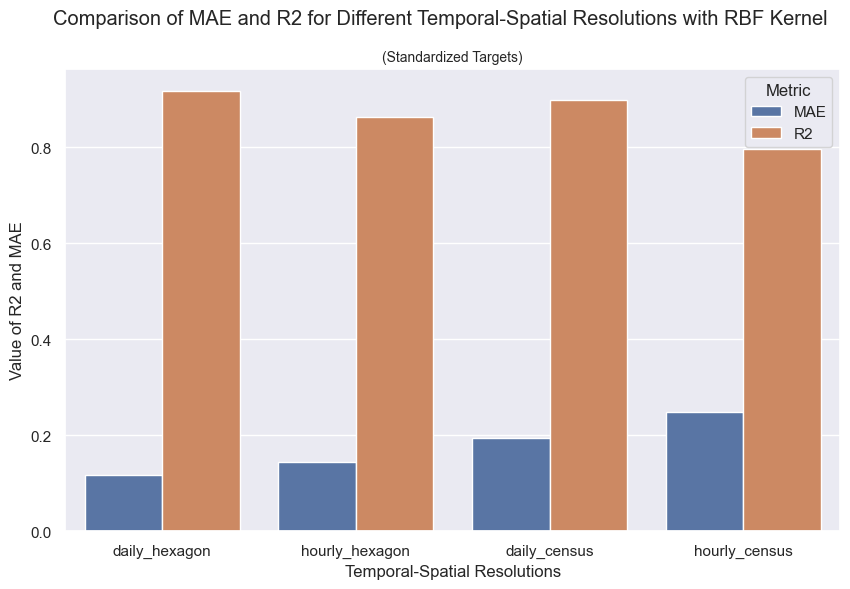

In [65]:
# Melt the DataFrame to long-form format for easier plotting with Seaborn
df_melted = pd.melt(df_rbf_approx, id_vars=['Data'], value_vars=['MAE', 'R2'], var_name='Metric', value_name='Value')

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Data', y='Value', hue='Metric', data=df_melted)

# Set titles and labels
plt.suptitle('Comparison of MAE and R2 for Different Temporal-Spatial Resolutions with RBF Kernel')
plt.title('(Standardized Targets)', fontsize=10)
plt.xlabel('Temporal-Spatial Resolutions')
plt.ylabel('Value of R2 and MAE')

# Display the plot
plt.show()

In [60]:
data_poly = {
    'Data': ['daily_hexagon', 'hourly_hexagon', 'daily_census', 'hourly_census'],
    'MAE': [daily_hexagon_mae_poly_approx_test, hourly_hexagon_mae_poly_approx_test, daily_census_mae_poly_approx_test, hourly_census_mae_poly_approx_test],
    'MSE': [daily_hexagon_mse_poly_approx_test, hourly_hexagon_mse_poly_approx_test, daily_census_mse_poly_approx_test, hourly_census_mse_poly_approx_test],
    'R2': [daily_hexagon_r2_poly_approx_test, hourly_hexagon_r2_poly_approx_test, daily_census_r2_poly_approx_test, hourly_census_r2_poly_approx_test]
}

df_poly_approx = pd.DataFrame(data_poly)
display(df_poly_approx)


,Data,MAE,MSE,R2
0,daily_hexagon,0.099431,0.078798,0.921193
1,hourly_hexagon,0.158477,0.112547,0.887452
2,daily_census,0.147944,0.102837,0.897153
3,hourly_census,0.244690,0.218605,0.781392


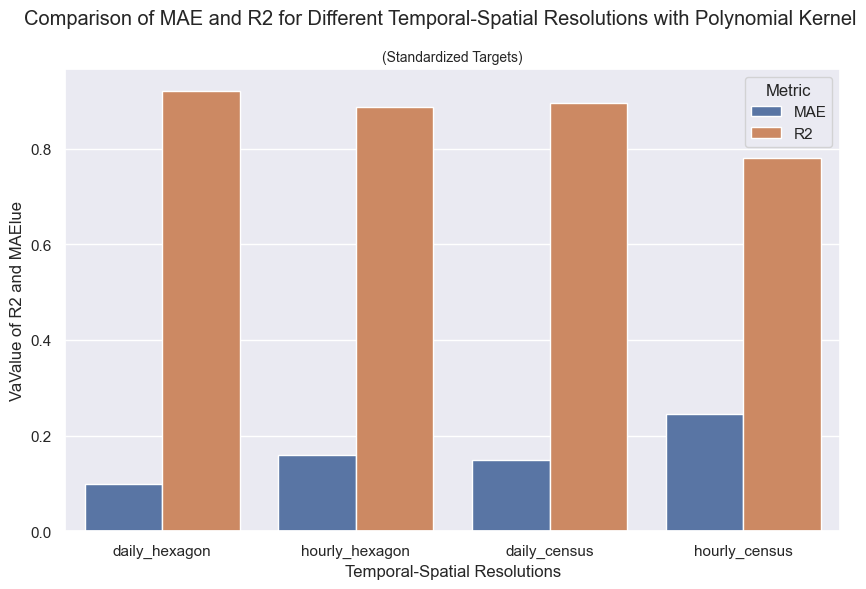

In [66]:
# Melt the DataFrame to long-form format for easier plotting with Seaborn
df_melted = pd.melt(df_poly_approx, id_vars=['Data'], value_vars=['MAE', 'R2'], var_name='Metric', value_name='Value')

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Data', y='Value', hue='Metric', data=df_melted)

# Set titles and labels
plt.suptitle('Comparison of MAE and R2 for Different Temporal-Spatial Resolutions with Polynomial Kernel')
plt.title('(Standardized Targets)', fontsize=10)
plt.xlabel('Temporal-Spatial Resolutions')
plt.ylabel('VaValue of R2 and MAElue')

# Display the plot
plt.show()